# Imports and seed

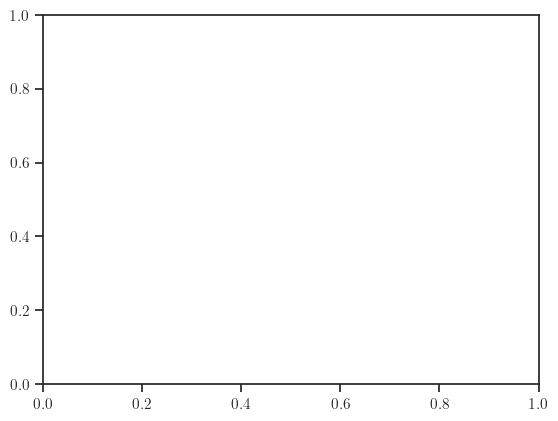

In [2]:
#!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

**Packages**

In [3]:
#!pip install numpyro
%matplotlib inline
from typing import Callable
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import scipy
from jax import random, Array, jit, vmap, grad
from jax.tree_util import Partial as partial
from jax.lax import fori_loop, cond, dynamic_slice
import numpyro
#import optax
import jax
#from jax.config import config

C:\Users\rouau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
#optax.clip_by_global_norm(1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle




**Seed**

In [6]:
key = random.PRNGKey(0)

# **Target measure (Gibbs)**



In [7]:
class gibbs(numpyro.distributions.Distribution) :

    def __init__(self, d, N, K, V, beta_N) :

        self.N = N
        self.K = K
        self.V = V
        self.d = d
        self.beta_N = beta_N
        event_shape = (N, d)
        super(gibbs, self).__init__(event_shape = event_shape)


    def log_prob(self, value) :

        #value = (x_1, \dots, x_N)

        value_shape = value.shape #should be (1, N*d)
        X = jnp.array(value.reshape(self.d, self.N))
        index = jnp.array([k for k in range(self.N)])

        k_inter = lambda j ,k : self.K(X[:, j], X[:, k])

        pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index).sum()
        diag = jit(vmap(k_inter))(index, index).sum()
        #diag = 0
        pair_jit = jit(vmap(pair_j))(index).sum()
        #pair_jit = jnp.array([[k_inter(j, k) for k in index] for j in index]).sum()
        #pair_inter = jnp.log(self.beta_N) +jnp.log(pair_jit - diag ) -jnp.log(2) - 2*jnp.log(self.N)
        pair_inter = self.beta_N * (pair_jit - diag) / (2 * self.N**2)

        v_inter = lambda j : self.V(X[:, j])
        ext_jit = jit(vmap(v_inter))(index).sum()
        #ext_jit = jnp.array([v_inter(j) for j in index]).sum()
        #exter_V =  jnp.log(self.beta_N) +jnp.log(ext_jit) - jnp.log(self.N)
        exter_V = self.beta_N * ext_jit / self.N

        return - pair_inter - exter_V
        #return  -jnp.exp(exter_V)*(jnp.exp(pair_inter - exter_V) +1)




In [10]:
def norm_2_safe_for_grad(x) :

      return jnp.power(jnp.linalg.norm(jnp.where(x != 0., x, 0.)), 2)

def V(x) :

    return -0.5 + 0.5*norm_2_safe_for_grad(x)
    #return jnp.power(jnp.linalg.norm(x), 2)

def K_gauss(x, y) :

      return jnp.exp(-0.5* norm_2_safe_for_grad(x - y))

def K(x, y, eps = 1e-5) :

    return - jnp.log(jnp.linalg.norm(x-y)**2 + eps**2)
    #return (jnp.linalg.norm(x-y)**2 + eps**2)**(-(d-2)/2)

def g(x, y, eps = 1e-2) :

    return -0.5*jnp.log(norm_2_safe_for_grad(x-y) + eps**2)

In [11]:
d = 2
N = 100 #la dim est Nd (on concatène)
beta_N = 2*N**2
target = gibbs(d, N, K_gauss, V, beta_N)

In [12]:
key, _ = random.split(key, 2)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(N*d), covariance_matrix= jnp.eye(N*d))
mvn_samples = mvn.sample(key, (1,))
target.log_prob(mvn_samples)

Array(-13208.65279234, dtype=float64)

# Basic MH

In [13]:
def metropolis_hastings(key: Array,
                        start_sample: Array,
                        log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
                        n_iter: int,
                        step_size: float,) -> jnp.ndarray:
    '''
    This function implements the metropolis hastings sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param step_size: float The standard deviation of the Gaussian kernel.
    :param n_iter: int The number of iterations on metropolis hastings
    :return:  Numpy array with the last sample
    '''
    val = (start_sample, key, 0.)
    def calculate_ratio(i, val):
        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        next = random.normal(subkey_sample, (sample.shape[-1],))*step_size + sample
        log_u = jnp.log(random.uniform(subkey_u))
        log_ratio = log_prob_target(next) - log_prob_target(sample)
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        acceptance = (i*acceptance + accept)/(i+1)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=calculate_ratio,
                          init_val=val)
    return sample, acceptance

In [14]:
key, _ = random.split(key, 2)
d = 2
N = 1_00
beta_N = N**3
target = gibbs(d, N, g, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [15]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(metropolis_hastings,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size = 0.9 * beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [16]:
acceptance

Array([0.965], dtype=float64, weak_type=True)

(np.float64(-2.9952186743929365),
 np.float64(2.5315119613666455),
 np.float64(-2.608192020169572),
 np.float64(2.8094813982120597))

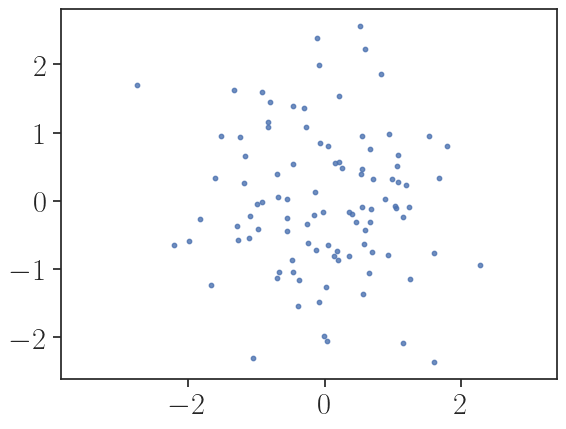

In [17]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

# **Basic MALA**

In [18]:
def mala(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel

        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + step_size * grad_logpdf(sample) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next - step_size * grad_logpdf(next))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob



        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        acceptance = (i*acceptance + accept)/(i+1)

        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

In [19]:
key, _ = random.split(key, 2)
d = 2
N = 100
beta_N = N**3
target = gibbs(d, N, g, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [20]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size =  0.9 * beta_N**(-1))))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [21]:
acceptance

Array([0.995], dtype=float64, weak_type=True)

In [ ]:
scales_temp_5_2_riesz_5000 = {500 :0.9,
                              450 : 0.9,
                              400 : 0.85,
                              350 : 0.85,
                              300  : 0.83,
                              250 : 0.83,
                              200 : 0.81,
                              150 : 0.8,
                              100 : 0.78,
                              50 : 0.79
                              }
pickle.dump(scales_temp_5_2_riesz_5000, open("drive/MyDrive/results_kernel/step_size_5_2_5000.p", "wb"))

In [ ]:
scales_temp_3_riesz_5000 = {50 : 0.80,
                            100 : 0.598,
                            150 : 0.090,
                            200 : 0.085,
                            250 : 0.09,
                            300 : 0.75,
                            350 : 0.06,
                            400 : 0.08,
                            450 : 0.070,
                            500 : 0.065}

pickle.dump(scales_temp_3_riesz_5000, open("drive/MyDrive/results_kernel/step_size_3_5000.p", "wb"))

(np.float64(-1.0279652740013414),
 np.float64(1.0128524022227143),
 np.float64(-1.0317590155165508),
 np.float64(1.0149375518910675))

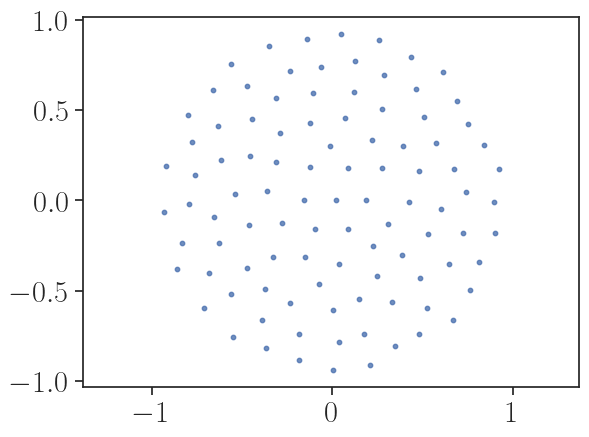

In [22]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")


In [ ]:
scales_temp_2_gauss_5000 = {500 :0.5,
                            550 : 0.5,
                            600 : 0.5,
                            450 :0.5,
                            400 : 0.55,
                            350 : 0.55,
                            300 : 0.56,
                            250 : 0.58,
                            200 : 0.58,
                            150 : 0.61,
                            100 : 0.62,
                            50 : 0.64
                            }

In [ ]:
scales_temp_3_2_riesz_5000 = {50 : 1.5,
                             100 : 1.5,
                             150 : 1.5,
                             200 : 1.5,
                             250 : 1.5,
                             300 : 1.5,
                             350 : 1.5,
                             400 : 1.5,
                             450 : 1.5,
                             500 : 1.5}

In [ ]:
scales_temp_2_riesz_5000 = {50 : 0.80,
                            100 : 0.80,
                            150 : 0.75,
                            200 : 0.7,
                            250 : 0.7,
                            300 : 0.65,
                            350 : 0.65,
                            400 : 0.6,
                            450 : 0.58,
                            500 : 0.55}

pickle.dump(scales_temp_2_riesz_5000, open("drive/MyDrive/results_kernel/step_size_2_5000.p", "wb"))


# **Tamed MALA**

In [ ]:
def mala_tamed(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float,) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        grad_sample = grad_logpdf(sample)
        next = sample + step_size * grad_sample / (1+step_size *jnp.linalg.norm(grad_sample)) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        bwd_ker_logprob = - ((sample - next - step_size * grad_next/(1+step_size * jnp.linalg.norm(grad_next)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        acceptance = (i*acceptance + accept)/(i+1)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

In [ ]:
key, _ = random.split(key, 2)
d = 2
N = 500
beta_N = N**2
target = gibbs(d, N, g, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix=  jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [ ]:
key, _ = random.split(key, 2)
sample_mala_tamed = jit(vmap(partial(mala_tamed,
                               log_prob_target = target.log_prob,
                               n_iter = 10_000,
                               step_size = 1e-3)))(random.split(key, 1), start_sample)
sample_mala_tamed_reshaped = sample_mala_tamed.reshape(N, d).T

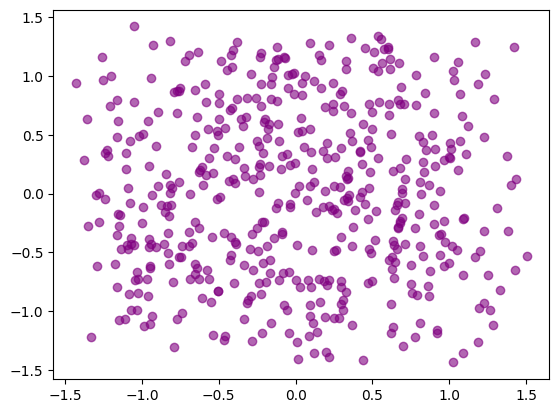

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_tamed_reshaped, alpha = 0.6, color = "purple")

# **MALA Tamed Particle-wise**

In [ ]:
def mala_tamed_pwise(key: Array,
         start_sample: Array,
         N : int,
         d : int,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float,) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        sample, key, acceptance = val
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        grad_sample = grad_logpdf(sample)
        grad_sample_reshaped = grad_sample.reshape(d, N)
        norm_grad_k = lambda k : jnp.linalg.norm(grad_sample_reshaped[:, k])
        norm_grad_pwise_jit = jit(vmap(norm_grad_k))(jnp.array([k for k in range(N)]))
        norm_grad_pwise = jnp.tile(norm_grad_pwise_jit, (d, 1)).T
        #norm_grad_pwise = jnp.array([jnp.linalg.norm(grad_sample_reshaped[k, :])*jnp.ones(d) for k in range(N)])

        next = sample + step_size * grad_sample / (jnp.ones_like(sample)+step_size * norm_grad_pwise.reshape(d*N)) \
               + jnp.sqrt(2 * step_size) * noise

        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        grad_next = grad_logpdf(next)
        grad_next_reshaped = grad_next.reshape(N, d)
        norm_grad_next_k = lambda k : jnp.linalg.norm(grad_next_reshaped[k, :])
        norm_grad_next_pwise_jit = jit(norm_grad_next_k)(jnp.array([k for k in range(N)]))
        norm_grad_next_pwise = jnp.tile(norm_grad_pwise_jit, (d, 1)).T
        #norm_grad_next_pwise = jnp.array([jnp.linalg.norm(grad_next_reshaped[k, :])*jnp.ones(d) for k in range(N)])

        bwd_ker_logprob = - ((sample - next - step_size * grad_next/(jnp.ones_like(next)+step_size * norm_grad_next_pwise.reshape(d*N)))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        acceptance = (i*acceptance + accept)/(i+1)
        return (x, key, acceptance)

    sample, k, acceptance = fori_loop(0,
                          n_iter,
                          body_fun=mh_step,
                          init_val=val)
    return sample, acceptance

In [ ]:
key, _ = random.split(key, 2)
d = 2
N = 1_000
beta_N = N**3
target = gibbs(d, N, g, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [ ]:
key, _ = random.split(key, 2)
sample_mala_tamed_pwise_jit = vmap(partial(mala_tamed_pwise,
                                           N = N,
                                           d = d,
                                           log_prob_target = target.log_prob,
                                           n_iter = 5_000,
                                           step_size = beta_N**-1))

In [ ]:
sample_mala_tamed_pwise = jit(sample_mala_tamed_pwise_jit)(random.split(key, 1), start_sample)
sample_pwise_reshaped = sample_mala_tamed_pwise.reshape(d, N)

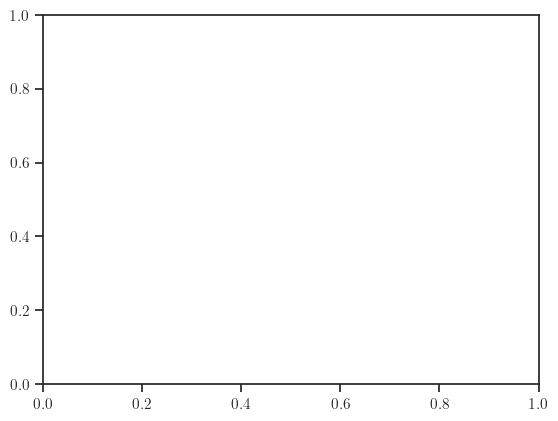

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks");

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
#axis equal
#plot.grid.on pour les variances / energies

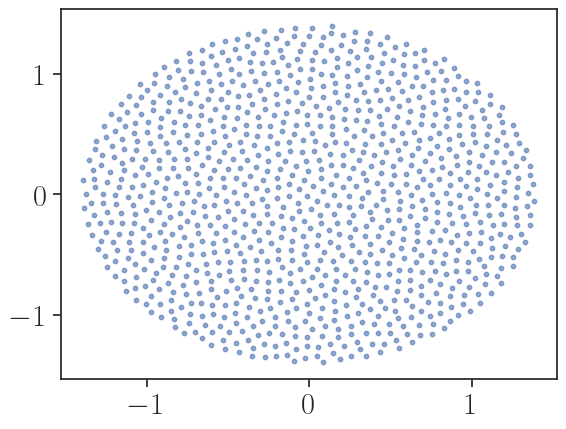

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_pwise_reshaped, alpha = 0.6, s = 10)

# **Target measure $\pi$, computing the potential and energies with MCMC samples**

## Target measure and kernels

In [12]:
d = 10
R = 1

In [ ]:
#Define the target

class unif(numpyro.distributions.Distribution) :

    def __init__(self, d, R) :

        self.d = d
        self.R = R
        event_shape = (self.d, )
        super(unif, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        value_shape = value.shape
        logprob = self.d*jnp.log(self.R) + self.d/2 * jnp.log(jnp.pi) - jnp.log(scipy.special.gamma(1+self.d/2))
        outlier = jnp.linalg.norm(value) >= self.R

        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : -logprob,
                   None)

        return res

In [15]:
#Define K, V_ext
def norm_2_safe_for_grad(x) :

      return jnp.power(jnp.linalg.norm(jnp.where(x != 0., x, 0.)), 2)


def K_riesz(x, y) : #eps = 10**-1

    return jnp.power(norm_2_safe_for_grad(x-y) + 10**-2, -(d-2)/2)

def K_gauss(x, y) :

    return jnp.exp(-0.5* norm_2_safe_for_grad(x-y))

def V_ext(x) :

    outlier = norm_2_safe_for_grad(x) >= 1
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - 1, 0.)

    return res

## MCMC steps

In [23]:
#MH
def mh(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)

    def mh_step(i, val):

        positions, key, acceptance = val
        sample = positions[i-1, :]
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel
        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next)**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob

        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)

        acceptance = (i*acceptance + accept)/(i+1)
        positions = positions.at[i, :].set(x)
        return (positions, key, acceptance)

    all_positions = jnp.zeros((n_iter,)+start_sample.shape)
    positions, k, acceptance = fori_loop(1,
                          n_iter,
                          body_fun=mh_step,
                          init_val=(all_positions, key, 0.))
    return positions, acceptance

MCMC samples for the potential.

In [23]:
#Initialize MH
key, _ = random.split(key, 2)
n_iter = 1_000
target_pot = gaussian_trunc(10)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.1*jnp.eye(d))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample

In [18]:
key, _ = random.split(key, 2)

In [19]:
#Run MCMC to approximate the potential and define V = - U^{\pi} + V_ext
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.05))

In [20]:
sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_pot = sample_mh_pot_jit[1, :, :].T

MCMC samples for the energy

In [21]:
#Initialize MH
key, _ = random.split(key, 2)
n_iter = 10_000
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.5*jnp.eye(d))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.05))
sample_mh_energy_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_energy_1 = sample_mh_energy_jit[1, :, :].T

key, _ = random.split(key, 2)
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample
sample_mh_energy_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_energy_2 = sample_mh_energy_jit[1, :, :].T


## External potentials

In [22]:
def V_riesz(x) :

    d, N_mh = sample_mh_pot.shape
    k_inter = lambda j : K_riesz(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext(x) - v_inter

def V_gauss(x) :

    d, N_mh = sample_mh_pot.shape
    k_inter = lambda j : K_gauss(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext(x) - v_inter

## Compute energies

In [23]:
#Compute the interaction energies up to a constant :
def I_K_riesz(x_1, x_2) :
    '''
    x_1, x_2 : arrays (d, )
    '''
    d, N_1 = x_1.shape
    d, N_2 = x_2.shape
    index_1 = jnp.array([k for k in range(N_1)])
    index_2 = jnp.array([k for k in range(N_2)])
    k_inter = lambda j, k : K_riesz(x_1[:, j], x_2[:, k])
    pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index_2).sum()
    pair_inter = jnp.log((jit(vmap(pair_j))(index_1).sum())) - jnp.log(N_1) - jnp.log(N_2)

    return jnp.exp(pair_inter)

def I_riesz(x) :

    return I_K_riesz(x, x) - 2*I_K_riesz(x, sample_mh_energy_1) + I_K_riesz(sample_mh_energy_1, sample_mh_energy_2)

In [ ]:
def I_K_gauss(x_1, x_2) :
    '''
    x_1, x_2 : arrays (d, )
    '''
    d, N_1 = x_1.shape
    d, N_2 = x_2.shape
    index_1 = jnp.array([k for k in range(N_1)])
    index_2 = jnp.array([k for k in range(N_2)])
    k_inter = lambda j, k : K_gauss(x_1[:, j], x_2[:, k])
    pair_j = lambda j : jit(vmap(partial(k_inter, j)))(index_2).sum()
    pair_inter = jnp.log(jit(vmap(pair_j))(index_1).sum()) - jnp.log(N_1) - jnp.log(N_2)

    return jnp.exp(pair_inter)

def I_gauss(x) :

    return I_K_gauss(x, x) - 2*I_K_gauss(x, sample_mh_energy_1)#+ I_K_gauss(sample_mh_energy_1, sample_mh_energy_2)

# **Compare MH updates (Riesz kernel)**

In [ ]:
key, key_mh, key_mala, key_mala_t, key_mala_tp, _ = random.split(key, 6)
Nmax = 100

## Regularized Riesz kernel

In [ ]:
def I_N_riesz(N, key, update = "mala_tp", step_size = 1e-3, n_iter = 1_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**2
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (1, ))
    target = gibbs(d, N, K_riesz, V_riesz, beta_N)

    if update == "mh" :

        sample_gibbs = jit(vmap(partial(metropolis_hastings,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    elif update == "mala" :

        sample_gibbs = jit(vmap(partial(mala,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    elif update == "mala_t" :

        sample_gibbs = jit(vmap(partial(mala_tamed,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    elif update == "mala_tp" :

        sample_gibbs = jit(vmap(partial(mala_tamed_pwise,
                                        N = N,
                                        d = d,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    return I_riesz(sample_gibbs)

In [ ]:
keys_mh = random.split(key_mh, Nmax + 1)
I_decay_riesz_mh = jnp.array([I_N_riesz(k, keys_mh[k], update = "mh", step_size = 1e-3) for k in range(5, Nmax)])

NameError: name 'metropolis_hastings' is not defined

In [ ]:
keys_mala = random.split(key_mala, Nmax + 1)
I_decay_riesz_mala = jnp.array([I_N_riesz(k, keys_mala[k], update = "mala", step_size = 1e-3) for k in range(5, Nmax)])

In [ ]:
keys_mala_t = random.split(key_mala_t, Nmax + 1)
I_decay_riesz_mala_t = jnp.array([I_N_riesz(k, keys_mala_t[k], update = "mala_t", step_size = 1e-3) for k in range(5, Nmax)])

In [ ]:
keys_mala_tp = random.split(key_mala_tp, Nmax + 1)
I_decay_riesz_mala_tp = jnp.array([I_N_riesz(k, keys_mala_tp[k], update = "mala_tp", step_size = 1e-3) for k in range(5, Nmax)])

In [ ]:
fig, axes = plt.subplots()

axes.plot(I_decay_riesz_mh, label  = "Standard MH")
axes.plot(I_decay_riesz_mala, label = "MALA")
axes.plot(I_decay_riesz_mala_t, label = "Tamed MALA")
axes.plot(I_decay_riesz_mala_tp, label = "Particle-wise tamed MALA")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("I_K")

fig.savefig("mh_updates_riesz.png")

## Gaussian kernel

In [ ]:
def I_N_gauss(N, key, update = "mala", step_size = 1e-3, n_iter = 1_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**2
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (1, ))
    target = gibbs(d, N, K_gauss, V_gauss, beta_N)

    if update == "mala" :

        sample_gibbs = jit(vmap(partial(mala,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    elif update == "mala_tp" :

        sample_gibbs = jit(vmap(partial(mala_tamed_pwise,
                                        N = N,
                                        d = d,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, 1), start_sample).reshape(d, N)

    return I_gauss(sample_gibbs)

# **Compare Gibbs measure with MCMC and herding (for the Riesz and Gauss energy)**

In [ ]:
Nmax = 500

## MCMC particles

In [ ]:
#Initialize MH
key, _ = random.split(key, 2)
#N = 1
n_iter = 500
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.5*jnp.eye(d))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.05))
sample_mh_energy_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_test = sample_mh_energy_jit[1, :, :].T
I_decay_mh_riesz = jnp.array([I_riesz(sample_mh_test[:, :k]) for k in [50*j for j in range(1, 11)]])
acceptance

In [ ]:
I_decay_mh_riesz = jnp.array([I_riesz(sample_mh_test[:, :k]) for k in range(5, n_iter)])

KeyboardInterrupt: 

In [ ]:
I_decay_mh_riesz_c = I_decay_mh_riesz + I_K_riesz(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(I_decay_mh_riesz.shape)

In [ ]:
I_decay_mh_gauss = jnp.array([I_gauss(sample_mh_test[:, :k]) for k in range(5, n_iter)])

In [ ]:
I_decay_mh_gauss_c = I_decay_mh_gauss + I_K_gauss(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(I_decay_mh_gauss.shape)

In [ ]:
dict_decay_mh = {"date" : "26/01/24",
                 "target" : "uniform on B_{3}(0, 1)",
                 "updates" : "MH with Gaussian proposal",
                 "n_samples" : 600,
                 "step_size" : 0.05,
                 "samples" : sample_mh_test,
                 "riesz_energy" : I_decay_mh_riesz_c,
                 "gauss_energy" : I_decay_mh_gauss_c,
                 "n_samples_energy" : 10_000,
}

In [ ]:
pickle.dump(dict_decay_mh, open("drive/MyDrive/results_kernel/decay_mh.p", "wb"))

In [ ]:
dict_decay_mh = pickle.load(open("drive/MyDrive/results_kernel/decay_mh.p", "rb"))

In [ ]:
I_decay_mh_riesz_c = dict_decay_mh["riesz_energy"]
I_decay_mh_gauss_c = dict_decay_mh["gauss_energy"]

## Riesz kernel particles

In [ ]:
Nmax = 600

In [ ]:
key, key_riesz, _ = random.split(key, 3)
keys_mala_tp = random.split(key_riesz, Nmax)

In [ ]:
I_decay_riesz_mala_0 = jnp.array([I_N_riesz(k, keys_mala_tp[k],
                                          update = "mala",
                                          step_size = 1e-2* k**(-1),
                                          n_iter = 1_000) for k in range(5, 300)])

In [ ]:
I_decay_riesz_mala_1 = jnp.array([I_N_riesz(k, keys_mala_tp[k],
                                          update = "mala",
                                          step_size = 1e-2* k**(-1),
                                          n_iter = 1_000) for k in range(301, 500)])

In [ ]:
I_decay_riesz_mala_2 = jnp.array([I_N_riesz(k, keys_mala_tp[k],
                                          update = "mala",
                                          step_size = 1e-2* k**(-1),
                                          n_iter = 1_000) for k in range(501, 600)])

In [ ]:
I_decay_riesz_mala = jnp.concatenate([I_decay_riesz_mala_0, I_decay_riesz_mala_1, I_decay_riesz_mala_2])

In [ ]:
I_decay_riesz_mala_c = I_decay_riesz_mala + I_K_riesz(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(I_decay_riesz_mala.shape)

In [ ]:
dict_decay_mala_riesz = {"date" : "26/01/24",
                            "target" : "uniform on B_{3}(0, 1)",
                            "Nmax" : 600,
                            "updates" : "MALA",
                            "n_iter" : 1_000,
                            "step_size" : "0.01* N**(-1)",
                            "riesz_energy" : I_decay_riesz_mala_c,
                            "n_samples_pot" : 1_000,
                            "n_samples_energy" : 10_000,
                            "riesz_coeff" : "d-2",
                            "riesz_reg" : "0.1",
                            "beta_N" : "N^2"
                            }
pickle.dump(dict_decay_mala_riesz, open("drive/MyDrive/results_kernel/decay_riesz_step_size.p", "wb"))
#pickle.load(open("decay_riesz_5000.p", "rb"))

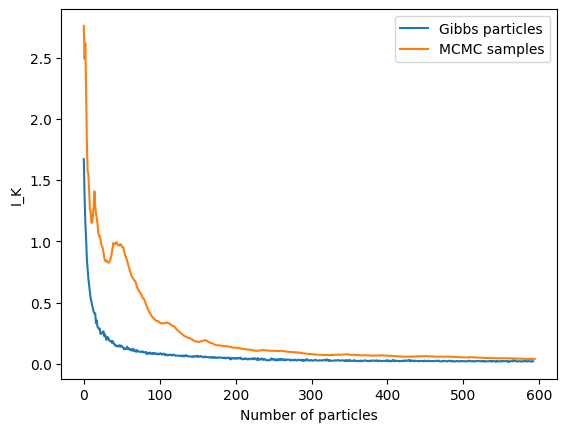

In [ ]:
fig, axes = plt.subplots()

axes.plot(I_decay_riesz_mala_c, label = "Gibbs particles")
axes.plot(I_decay_mh_riesz_c, label = "MCMC samples")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("I_K")

fig.savefig("mcmc_vs_riesz.png")

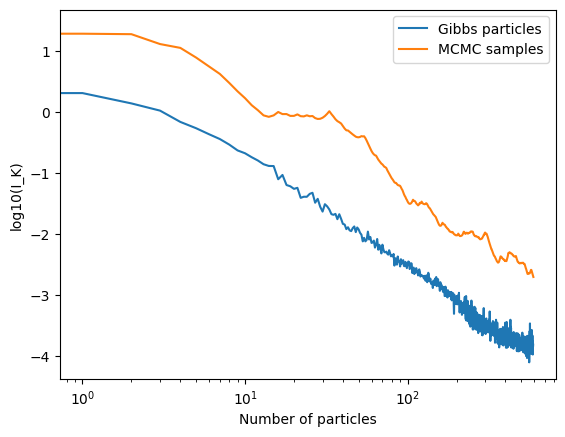

In [ ]:
fig, axes = plt.subplots()

axes.plot(jnp.log(I_decay_riesz_mala_c), label = "Gibbs particles")
axes.plot(jnp.log(I_decay_mh_riesz_c), label = "MCMC samples")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("log10(I_K)")
axes.set_xscale("log")

#fig.savefig("mcmc_vs_riesz.png")

## Gaussian kernel particles

In [ ]:
Nmax = 600

In [ ]:
key, key_gauss, _ = random.split(key, 3)
keys_mala_tp = random.split(key_gauss, Nmax)

In [ ]:
I_decay_gauss_mala_0 = jnp.array([I_N_gauss(k, keys_mala_tp[k],
                                          update = "mala_tp",
                                          step_size = 1e-2* (k**-1),
                                          n_iter = 1_000) for k in range(5, 300)])

In [ ]:
I_decay_gauss_mala_1 = jnp.array([I_N_gauss(k, keys_mala_tp[k],
                                          update = "mala_tp",
                                          step_size = 1e-2 * (k**-1),
                                          n_iter = 1_000) for k in range(301, 500)])

In [ ]:
I_decay_gauss_mala_2 = jnp.array([I_N_gauss(k, keys_mala_tp[k],
                                          update = "mala_tp",
                                          step_size = 1e-2 * (k**-1),
                                          n_iter = 1_000) for k in range(501, 600)])

In [ ]:
I_decay_gauss_mala = jnp.concatenate([I_decay_gauss_mala_0,
                                      I_decay_gauss_mala_1,
                                      I_decay_gauss_mala_2 ])

In [ ]:
I_decay_gauss_mala_c = I_decay_gauss_mala + I_K_gauss(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(I_decay_gauss_mala.shape)

In [ ]:
dict_decay_mala_gauss = {"date" : "26/01/24",
                            "target" : "uniform on B_{3}(0, 1)",
                            "Nmax" : 600,
                            "kernel" : "Gaussian",
                            "updates" : "MALA",
                            "n_iter" : 1_000,
                            "step_size" : "0.01* N**(-1)",
                            "gauss_energy" : I_decay_gauss_mala,
                            "n_samples_pot" : 1_000,
                            "n_samples_energy" : 10_000,
                            "beta_N" : "N^2"
                            }
pickle.dump(dict_decay_mala_gauss, open("drive/MyDrive/results_kernel/decay_gauss_pwise.p", "wb"))

In [ ]:
#dict_decay_mala_gauss = pickle.load(open("drive/MyDrive/results_kernel/decay_gauss_5000_iter.p", "rb"))

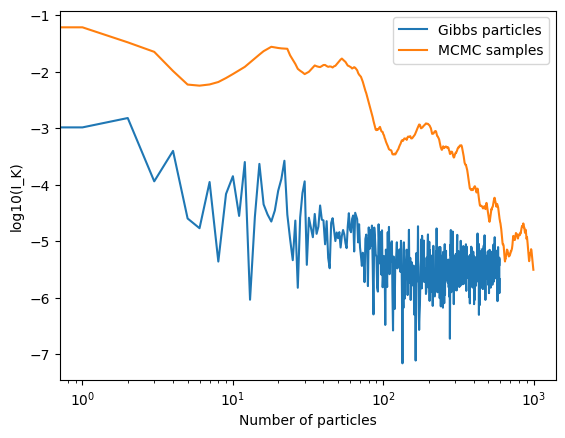

In [ ]:
fig, axes = plt.subplots()

axes.plot(jnp.log(I_decay_gauss_mala_c), label = "Gibbs particles")
axes.plot(jnp.log(I_decay_mh_gauss_c), label = "MCMC samples")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("log10(I_K)")
axes.set_xscale("log")

#fig.savefig("mcmc_vs_riesz.png")

Compare if possible with a herding algorithm ?

# **Compare variance**

In [17]:
Nmax = 500
d = 10
L_N = jnp.array([k*100 for k in range(1, 6)]).astype(int)
key, _ = random.split(key, 2)

Test function in the RKHS :

## MCMC

In [24]:
#Initialize MH
N_chains = 100
n_iter = 500
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.5*jnp.eye(d))
start_sample = mvn.sample(key, (N_chains, ))
initial_positions = start_sample
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.01))
sample_mh_energy_jit, acceptance = jit(sample_mh_jit)(random.split(key, N_chains), initial_positions)
#sample_mh_test = sample_mh_energy_jit[1, :, :].T

In [26]:
acceptance

Array([0.518, 0.45 , 0.468, 0.526, 0.468, 0.53 , 0.436, 0.462, 0.516,
       0.47 , 0.524, 0.494, 0.492, 0.498, 0.464, 0.532, 0.46 , 0.49 ,
       0.47 , 0.47 , 0.444, 0.48 , 0.496, 0.454, 0.452, 0.5  , 0.496,
       0.426, 0.518, 0.47 , 0.48 , 0.518, 0.47 , 0.494, 0.464, 0.496,
       0.492, 0.48 , 0.462, 0.466, 0.478, 0.446, 0.468, 0.444, 0.476,
       0.47 , 0.496, 0.432, 0.502, 0.462, 0.474, 0.45 , 0.48 , 0.476,
       0.428, 0.468, 0.448, 0.486, 0.46 , 0.51 , 0.442, 0.472, 0.466,
       0.496, 0.5  , 0.522, 0.53 , 0.474, 0.448, 0.468, 0.446, 0.5  ,
       0.46 , 0.46 , 0.452, 0.454, 0.452, 0.42 , 0.4  , 0.476, 0.49 ,
       0.52 , 0.478, 0.474, 0.422, 0.466, 0.478, 0.474, 0.5  , 0.478,
       0.464, 0.462, 0.47 , 0.428, 0.418, 0.48 , 0.492, 0.466, 0.448,
       0.41 ], dtype=float64, weak_type=True)

In [25]:
k_riesz = lambda k, i : K_riesz(x = sample_mh_energy_jit[i, k, :], y = jnp.zeros(d))
pot_mh_i = lambda i, l : jit(vmap(partial(k_riesz,
                                          i = i)))(jnp.arange(l)).sum()/l
var_l = lambda l : jit(vmap(partial(pot_mh_i,
                                    l = l)))(jnp.arange(N_chains)).var()

In [28]:
L_N = [100*k for k in range(1 ,6)]

In [26]:
V_mh = jnp.array([var_l(l) for l in L_N])

In [27]:
V_mh

Array([1.05594782e+11, 2.63986605e+10, 1.17327217e+10, 6.59960588e+09,
       4.22374882e+09], dtype=float64)

## Gibbs measure (Riesz)

In [31]:
def var_N_riesz(N, key, N_chains = 50, update = "mala_tp", temp_scale = 2, step_size = 1e-3, n_iter = 5_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**temp_scale
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (N_chains, ))
    target = gibbs(d, N, K_riesz, V_riesz, beta_N)

    if update == "mala" :

        sample_gibbs, acceptance = jit(vmap(partial(mala,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, N_chains), start_sample)
        print(acceptance)

    elif update == "mala_tp" :

        sample_gibbs, acceptance = jit(vmap(partial(mala_tamed_pwise,
                                        N = N,
                                        d = d,
                                        log_prob_target = target.log_prob,
                                        n_iter = n_iter,
                                        step_size = step_size)))(random.split(key_sample, N_chains), start_sample)
                                        #.reshape(N_chains, d, N)

    k_riesz = lambda k, i : K_riesz(x = sample_gibbs[i, :].reshape(d, N)[:, k], y = jnp.zeros(d))
    pot_mh_i = lambda i, l : jit(vmap(partial(k_riesz,
                                          i = i)))(jnp.arange(l)).sum()/l
    var_l =  jit(vmap(partial(pot_mh_i,
                              l = N)))(jnp.arange(N_chains)).var()

    return var_l

In [32]:
var_riesz_10d_temp = {}

In [28]:
var_riesz_10d_temp = pickle.load(open("drive/MyDrive/var_riesz_10d_temp.p", "rb"))

In [46]:
var_riesz_10d_temp

{'100': Array(0.0040723, dtype=float64),
 '200': Array(0.06382415, dtype=float64),
 '300': Array(0.00143767, dtype=float64),
 '400': Array(0.00059436, dtype=float64),
 '500': Array(0.00040462, dtype=float64)}

In [37]:
h = 2
k = 100*h
key, _ = random.split(key, 2)
var_h = var_N_riesz(k, key, N_chains = 100, update = "mala", temp_scale = 2, step_size = 0.001 * k**(-2), n_iter = 5_000)
var_riesz_10d_temp["200"] = var_h
pickle.dump(var_riesz_10d_temp, open("drive/MyDrive/var_riesz_10d_temp.p", "wb"))

[0.2372 0.3176 0.3192 1.     0.9334 0.9994 0.3708 1.     0.2242 0.1206
 0.7848 0.1364 0.86   0.382  0.3904 1.     1.     1.     0.1182 0.1134
 1.     0.799  0.1212 1.     1.     0.3798 1.     0.547  1.     0.9998
 0.0256 1.     0.6524 1.     0.3918 1.     1.     1.     0.2718 0.0412
 0.5208 0.9956 0.5066 0.8638 0.1498 0.1218 1.     1.     0.9998 0.0942
 0.0062 0.8094 0.4652 0.3504 0.1794 0.9902 0.7252 0.1884 0.0698 0.778
 0.9996 1.     1.     1.     0.1252 0.9998 1.     1.     0.8594 0.4556
 0.1548 0.1664 1.     1.     1.     0.169  0.0136 0.9998 0.5704 0.0202
 0.1622 0.9998 0.967  0.6568 0.175  0.5354 1.     0.0366 1.     0.6064
 0.4466 0.968  1.     1.     0.9998 1.     0.5744 0.5534 0.6708 0.2668]


In [43]:
h = 3
k = 100*h
key, _ = random.split(key, 2)
var_h = var_N_riesz(k, key, N_chains = 100, update = "mala", temp_scale = 2, step_size = 0.001 * k**(-2), n_iter = 5_000)
var_riesz_10d_temp["300"] = var_h
pickle.dump(var_riesz_10d_temp, open("drive/MyDrive/var_riesz_10d_temp.p", "wb"))

[0.3934 0.9998 0.9998 0.4894 0.4062 1.     0.5902 0.314  1.     1.
 1.     0.6446 1.     0.0272 0.3632 0.2364 0.0214 1.     0.3448 0.1762
 1.     1.     1.     0.4194 0.9998 1.     0.0152 0.9996 1.     0.3664
 0.9998 1.     0.638  0.9998 0.9998 0.6018 1.     1.     0.3136 0.2968
 0.0656 1.     0.3594 0.0482 0.0488 0.     0.878  1.     0.9998 0.414
 0.45   0.7776 0.4362 1.     0.6292 0.0274 0.244  1.     0.0418 0.0924
 0.9756 1.     1.     1.     0.403  0.8528 0.9998 0.488  0.2662 0.3572
 0.2182 0.537  0.0828 1.     0.4814 1.     1.     1.     1.     0.6808
 1.     1.     0.3362 0.7582 0.0372 0.6474 1.     0.3964 0.156  0.9994
 1.     1.     0.1326 0.1546 0.023  1.     1.     0.5708 0.9528 0.6186]


In [44]:
h = 4
k = 100*h
key, _ = random.split(key, 2)
var_h = var_N_riesz(k, key, N_chains = 100, update = "mala", temp_scale = 2, step_size = 0.001 * k**(-2), n_iter = 5_000)
var_riesz_10d_temp["400"] = var_h
pickle.dump(var_riesz_10d_temp, open("drive/MyDrive/var_riesz_10d_temp.p", "wb"))

[1.     0.0304 0.8384 0.6288 1.     0.4506 1.     0.0032 0.1824 1.
 1.     0.9462 1.     0.3976 0.0612 0.3554 0.9528 0.4858 0.0292 0.857
 0.002  0.2588 0.1804 1.     0.4428 1.     0.322  0.7632 1.     0.5042
 0.228  1.     0.999  0.405  0.538  0.5682 0.4194 0.5662 1.     0.8174
 0.1304 1.     0.9994 0.4884 0.3184 0.8862 0.9996 1.     1.     0.4036
 1.     0.766  0.1894 0.2718 0.3086 0.4292 0.9992 0.9554 1.     0.276
 1.     1.     0.0168 0.1158 1.     0.607  1.     0.9996 0.2192 1.
 0.3252 0.1856 0.9998 0.602  1.     0.1666 0.8392 0.0332 1.     1.
 0.1142 1.     0.2942 0.278  0.2562 1.     0.0572 0.5992 0.735  0.1168
 0.9902 0.1298 1.     0.257  0.482  1.     0.3934 0.0518 0.9996 1.    ]


In [45]:
h = 5
k = 100*h
key, _ = random.split(key, 2)
var_h = var_N_riesz(k, key, N_chains = 100, update = "mala", temp_scale = 2, step_size = 0.0005 * k**(-2), n_iter = 5_000)
var_riesz_10d_temp["500"] = var_h
pickle.dump(var_riesz_10d_temp, open("drive/MyDrive/var_riesz_10d_temp.p", "wb"))

[0.     0.5066 1.     1.     0.3164 1.     0.513  0.066  1.     1.
 1.     0.081  1.     1.     0.288  1.     0.4622 1.     1.     0.9998
 1.     1.     0.0824 1.     0.3516 1.     0.9998 0.9996 0.7694 1.
 1.     0.4876 0.486  0.9998 0.8036 1.     1.     1.     1.     0.459
 1.     0.9966 0.999  0.9998 0.2886 0.7446 1.     1.     0.5062 1.
 1.     0.4168 0.2732 1.     1.     0.2424 1.     1.     1.     1.
 1.     0.0402 0.412  1.     0.9916 1.     1.     0.9868 0.275  1.
 1.     1.     1.     0.5016 0.4104 0.7938 1.     1.     0.7388 1.
 1.     1.     1.     1.     1.     0.79   1.     1.     1.     1.
 1.     0.9264 0.9996 1.     0.9998 0.4836 0.7706 0.9998 0.9998 1.    ]


In [29]:
vars = jnp.array([var_riesz_10d_temp['100'], var_riesz_10d_temp['200'], var_riesz_10d_temp['300'], var_riesz_10d_temp['400'], var_riesz_10d_temp['500']])

In [ ]:
var_riesz_temp_5_2 = jnp.array([var_riesz_temp["50"], var_riesz_temp["100"],
                              var_riesz_temp["150"], var_riesz_temp["200"],
                              var_riesz_temp["250"], var_riesz_temp["300"],
                              var_riesz_temp["350"], var_riesz_temp["400"],
                              var_riesz_temp["450"], var_riesz_temp["500"]])

KeyError: '50'

In [ ]:
var_riesz_temp_5_2 = jnp.array([var_riesz_temp["500"] for k in range(10)])

In [ ]:
vars_riesz = pickle.load(open("drive/MyDrive/results_kernel/var_riesz_scale_5000.p", "rb"))
vars_riesz["gibbs_var_n_5_2"] = var_riesz_temp_5_2
vars_riesz["scales_n_5_2"] = scales_temp_5_2_riesz_5000
pickle.dump(vars_riesz, open("drive/MyDrive/results_kernel/var_riesz_scale_5000.p", "wb"))

In [ ]:
vars_riesz = pickle.load(open("drive/MyDrive/results_kernel/var_riesz_scale_5000.p", "rb"))
V_mh = vars_riesz["mcmc_var"]
var_riesz_temp_2 = vars_riesz["gibbs_var_n_2"]
var_riesz_temp_3_2 = vars_riesz["gibbs_var_n_3_2"]

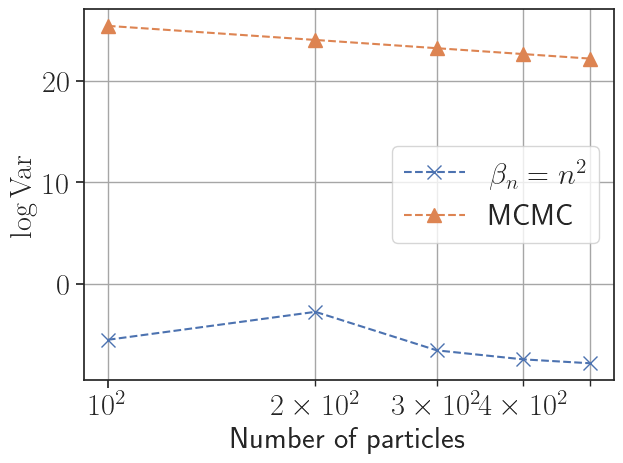

In [30]:
fig, axes = plt.subplots()

#axes.plot(L_N, jnp.log(var_riesz_temp_3), label = "$\\beta_n = n^3$", linestyle='--', marker='o')
#axes.plot(L_N, jnp.log(var_riesz_temp_3_2), label = "$\\beta_n = n^{3/2}$", linestyle = '--', marker = 'o', markersize = 10)
axes.plot(L_N, jnp.log(vars), label = "$\\beta_n =  n^2$", linestyle='--', marker='x', markersize = 10)
axes.plot(L_N, jnp.log(V_mh), label = "MCMC", linestyle='--', marker='^', markersize = 10)
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope=-1., linestyle = "dashed", color = "0.7")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope = -2., linestyle = "dashed", color = "0.7")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("$\\log \\mathrm{Var}$")
axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
fig.savefig("var_riesz.pdf")
fig.savefig("var_riesz.eps")

# Plot energy gauss

In [ ]:
scales_temp_2_gauss_5000 = {500 :0.5,
                            550 : 0.5,
                            600 : 0.5,
                            450 :0.5,
                            400 : 0.55,
                            350 : 0.55,
                            300 : 0.56,
                            250 : 0.58,
                            200 : 0.58,
                            150 : 0.61,
                            100 : 0.62,
                            50 : 0.64
                            }

Nmax = 600
for k in range(12) :
    for i in range(1, 50) :
        scales_temp_2_gauss_5000[50*k + i] = scales_temp_2_gauss_5000[50*(k+1)]

In [ ]:
Nmax = 600
L_N = jnp.array([10*k for k in range(1, 61)]).astype(int)

In [ ]:
def I_N_gauss(N, key, update = "mala", step_size = 1e-3, n_iter = 1_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**2
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (1, ))
    target = gibbs(d, N, K_gauss, V_gauss, beta_N)

    if update == "mala" :

        sample_gibbs, acceptance = jit(vmap(partial(mala,
                                                    log_prob_target = target.log_prob,
                                                    n_iter = n_iter,
                                                    step_size = step_size)))(random.split(key_sample, 1), start_sample)

    return I_gauss(sample_gibbs.reshape(d, N))

In [ ]:
key, key_gauss, _ = random.split(key, 3)
keys_mala_tp = random.split(key_gauss, Nmax)

In [ ]:
I_gauss_dict = pickle.load(open("drive/MyDrive/results_kernel/decay_gauss_5000.p", "rb"))

In [ ]:
for k in range(1, 61):
    h = 10*k
    print(h)
    I_k = I_N_gauss(h, keys_mala_tp[h],
                                          update = "mala",
                                          step_size = scales_temp_2_gauss_5000[h] * h**(-2),
                                          n_iter = 5_000)
    I_gauss_dict["I_decay_gauss"][k-1] = I_k #attention rajouter la constante ensuite
    pickle.dump(I_gauss_dict, open("drive/MyDrive/results_kernel/decay_gauss_5000.p", "wb"))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600


IndexError: list assignment index out of range

In [ ]:
k = 60
h = 600
I_k = I_N_gauss(h, keys_mala_tp[h],
                                          update = "mala",
                                          step_size = scales_temp_2_gauss_5000[h] * h**(-2),
                                          n_iter = 5_000)
I_gauss_dict["I_decay_gauss"][k-1] = I_k #attention rajouter la constante ensuite
pickle.dump(I_gauss_dict, open("drive/MyDrive/results_kernel/decay_gauss_5000.p", "wb"))

In [ ]:
I_gauss_dict = pickle.load(open("drive/MyDrive/results_kernel/decay_gauss_5000.p", "rb"))

In [ ]:
I_decay_gauss_c = jnp.array(I_gauss_dict["I_decay_gauss"]) +  I_K_gauss(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(jnp.array(I_gauss_dict["I_decay_gauss"]).shape)

In [ ]:
dict_decay_mala_gauss = {"date" : "30/01/24",
                            "target" : "uniform on B_{3}(0, 1)",
                            "Nmax" : 600,
                            "kernel" : "Gaussian",
                            "updates" : "MALA",
                            "n_iter" : 5_000,
                            "step_size" : "c* N**(-2)",
                            "gauss_energy" : I_decay_gauss_c,
                            "n_samples_pot" : 1_000,
                            "n_samples_energy" : 10_000,
                            "beta_N" : "N^2"
                            }
pickle.dump(dict_decay_mala_gauss, open("drive/MyDrive/results_kernel/decay_gauss_energy.p", "wb"))

In [ ]:
dict_decay_mala_gauss = pickle.load(open("drive/MyDrive/results_kernel/decay_gauss_energy.p", "rb"))
I_decay_gauss_c = dict_decay_mala_gauss["gauss_energy"]

EOFError: Ran out of input

In [ ]:
dict_decay_mh = pickle.load(open("drive/MyDrive/results_kernel/decay_mh.p", "rb"))

In [ ]:
I_mh_gauss = dict_decay_mh["gauss_energy"]
I_mh_gauss_10 = jnp.array([I_mh_gauss[10*k] for k in range(1, 61)])
L_N = jnp.array([10*k for k in range(1, 61)])

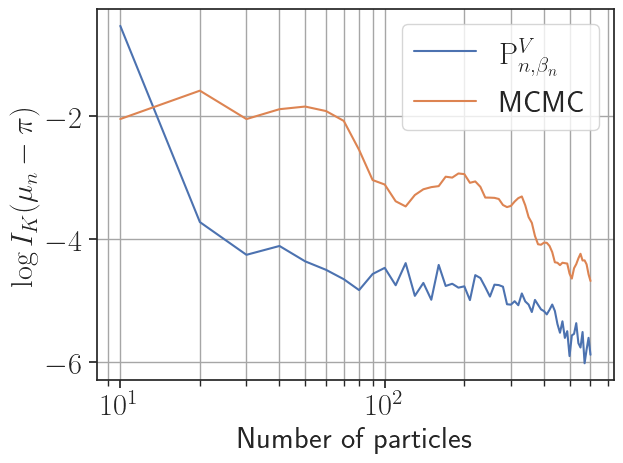

In [ ]:
fig, axes = plt.subplots()

axes.plot(L_N, jnp.log(I_decay_gauss_c), label = "$\\mathrm{P}_{n, \\beta_n}^{V}$")
axes.plot(L_N, jnp.log(I_mh_gauss_10), label = "MCMC")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope=-1., linestyle = "dashed", color = "0.7")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope = -2., linestyle = "dashed", color = "0.7")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("$\\log I_{K}(\\mu_n - \\pi)$")
axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
fig.savefig("energy_gauss.pdf")
fig.savefig("energy_gauss.eps")

# Plot energy Riesz

In [ ]:
scales_temp_2_riesz_5000 = {50 : 0.80,
                            100 : 0.80,
                            150 : 0.75,
                            200 : 0.7,
                            250 : 0.7,
                            300 : 0.65,
                            350 : 0.65,
                            400 : 0.6,
                            450 : 0.58,
                            500 : 0.55,
                            550 : 0.53,
                            600 : 0.5}

Nmax = 600
for k in range(12):
    for i in range(1, 50):
        scales_temp_2_riesz_5000[50*k + i] = scales_temp_2_riesz_5000[50*(k+1)]

In [ ]:
Nmax = 600
L_N = jnp.array([10*k for k in range(1, 61)]).astype(int)

In [ ]:
def I_N_riesz(N, key, update = "mala", step_size = 1e-3, n_iter = 1_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**2
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (1, ))
    target = gibbs(d, N, K_riesz, V_riesz, beta_N)

    if update == "mala" :

        sample_gibbs, acceptance = jit(vmap(partial(mala,
                                                    log_prob_target = target.log_prob,
                                                    n_iter = n_iter,
                                                    step_size = step_size)))(random.split(key_sample, 1), start_sample)

    return I_riesz(sample_gibbs.reshape(d, N))

In [ ]:
key, key_riesz, _ = random.split(key, 3)
keys_mala_tp = random.split(key_riesz, Nmax)
I_riesz_dict_10d = {"I_decay_riesz" : [0. for k in range(10)]}
for k in range(1, 11):
    h = 50*k
    I_k = I_N_riesz(h, keys_mala_tp[h],
                                          update = "mala",
                                          step_size = 0.01 * h**(-2),
                                          n_iter = 5_000)
    I_riesz_dict_10d["I_decay_riesz"][k-1] = I_k #attention rajouter la constante ensuite
    pickle.dump(I_riesz_dict_10d, open("drive/MyDrive/results_kernel/decay_riesz_gauss10d.p", "wb"))

In [ ]:
I_riesz_dict = {"I_decay_riesz" : [0. for k in range(60)]}

In [ ]:
for k in range(1, 61):
    h = 10*k
    print(h)
    I_k = I_N_riesz(h, keys_mala_tp[h],
                                          update = "mala",
                                          step_size = scales_temp_2_riesz_5000[h] * h**(-3),
                                          n_iter = 5_000)
    I_riesz_dict["I_decay_riesz"][k-1] = I_k #attention rajouter la constante ensuite
    pickle.dump(I_riesz_dict, open("drive/MyDrive/results_kernel/decay_riesz_n_3_5000.p", "wb"))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600


In [ ]:
I_decay_riesz_c_3 = jnp.array(I_riesz_dict["I_decay_riesz"]) +  I_K_riesz(sample_mh_energy_1, sample_mh_energy_2)*jnp.ones(jnp.array(I_riesz_dict["I_decay_riesz"]).shape)

In [ ]:
dict_decay_mala_riesz = {"date" : "30/01/24",
                            "target" : "uniform on B_{3}(0, 1)",
                            "Nmax" : 600,
                            "kernel" : "truncated Riesz",
                            "updates" : "MALA",
                            "n_iter" : 5_000,
                            "step_size" : "c* N**(-3)",
                            "gauss_energy" : I_decay_riesz_c_3,
                            "n_samples_pot" : 1_000,
                            "n_samples_energy" : 10_000,
                            "beta_N" : "N^3"
                            }
pickle.dump(dict_decay_mala_riesz, open("drive/MyDrive/results_kernel/decay_riesz_energy_n_3.p", "wb"))

In [ ]:
I_mh_riesz = dict_decay_mh["riesz_energy"]
I_mh_riesz_10 = jnp.array([I_mh_riesz[10*k] for k in range(1, 61)])
L_N = jnp.array([10*k for k in range(1, 61)])

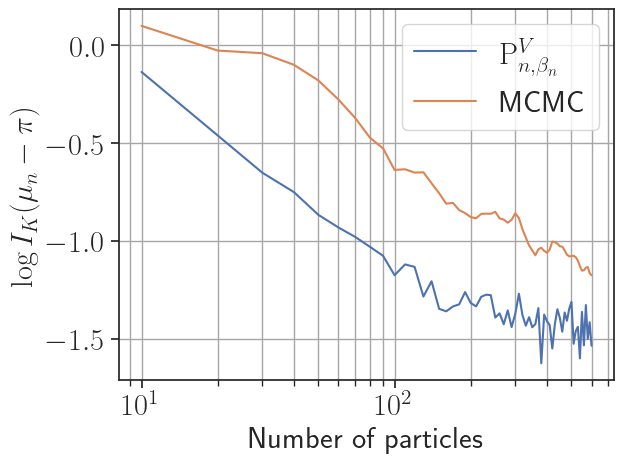

In [ ]:
fig, axes = plt.subplots()

axes.plot(L_N, jnp.log10(I_decay_riesz_c_3), label = "$\\mathrm{P}_{n, \\beta_n}^{V}$")
axes.plot(L_N, jnp.log10(I_mh_riesz_10), label = "MCMC")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope=-1., linestyle = "dashed", color = "0.7")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope = -2., linestyle = "dashed", color = "0.7")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("$\\log I_{K}(\\mu_n - \\pi)$")
axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
#fig.savefig("energy_riesz.pdf")
#fig.savefig("energy_riesz.eps")

# Multimodal example

## Define logprob of the target, compute the approximated kernel embedding

In [ ]:
d = 2
#R = 1
n_modes = 6

In [ ]:
#Define the target

class unif(numpyro.distributions.Distribution) :

    def __init__(self, d, R) :

        self.d = d
        self.R = R
        event_shape = (self.d, )
        super(unif, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        value_shape = value.shape
        logprob = self.d*jnp.log(self.R) + self.d/2 * jnp.log(jnp.pi) - jnp.log(scipy.special.gamma(1+self.d/2))
        outlier = jnp.linalg.norm(value) >= self.R

        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : -logprob,
                   None)

        return res

class unif_mixture(numpyro.distributions.Distribution) :

    def __init__(self, d, n_modes, R) :

        self.d = d
        self.R = R
        self.n_modes = n_modes
        self.centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])
        #self.radii = 1/d
        event_shape = (self.d, )
        super(unif_mixture, self).__init__(event_shape = event_shape)


    def log_prob_k(self, k, value) :

        outlier = jnp.linalg.norm(value - self.centers[k]) >= self.R[k]
        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : - self.d*jnp.log(self.R[k]) + self.d/2 * jnp.log(jnp.pi) - jnp.log(scipy.special.gamma(1+self.d/2)),
                   None)
        return res

    def log_prob(self, value) :

        resk = jnp.array([jnp.exp(self.log_prob_k(k, value)) for k in range(self.n_modes)]).sum()
        return jnp.log(resk)

class gaussian_trunc(numpyro.distributions.Distribution) :

    def __init__(self, d):

        self.d = d
        self.sigma = 1
        event_shape = (self.d, )
        super(gaussian_trunc, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        outlier = jnp.linalg.norm(value) >= 1.
        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : -jnp.linalg.norm(value)**2/(2*self.sigma**2),
                   None)

        return res

class gaussian_trunc_mixture(numpyro.distributions.Distribution) :

    def __init__(self, d, n_modes) :

        self.d = d
        self.n_modes = n_modes
        self.radii = 1/d
        self.sigma = jnp.sqrt(0.1)
        self.centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])
        event_shape = (self.d, )
        super(gaussian_trunc_mixture, self).__init__(event_shape = event_shape)

    def log_prob_k(self, k, value) :

        outlier = jnp.linalg.norm(value - self.centers[k]) >= self.radii
        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : - jnp.linalg.norm(value - self.centers[k])**2/(2*self.sigma**2) - d/2 *jnp.log(2*jnp.pi*self.sigma**2),
                   None)
        return res

    def log_prob(self, value) :

        resk = jnp.array([jnp.exp(self.log_prob_k(k, value)) for k in range(self.n_modes)]).sum()
        return jnp.log(resk)





In [ ]:
#Define K, V_ext
def norm_2_safe_for_grad(x) :

      return jnp.power(jnp.linalg.norm(jnp.where(x != 0., x, 0.)), 2)


def K_log(x, y) : #eps = 10**-1

    #return jnp.power(norm_2_safe_for_grad(x-y) + 10**-2 , (d+1)/2)
    return -0.5*jnp.log(norm_2_safe_for_grad(x-y) +10**-2)
    #return -jnp.power(norm_2_safe_for_grad(x-y), 2)

def V_ext(x) :

    outlier = norm_2_safe_for_grad(x) >= (2)**2
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - (2)**2, 0.)

    #outlier = (target_pot.log_prob(x) == -jnp.inf)
    #res = jnp.where(outlier, jnp.inf, 0.)

    return res

def V_ext_R(x, R):

    outlier = norm_2_safe_for_grad(x) >= (R)**2
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - (R)**2, 0.)
    return res


def V_ext_mixture(x, R) :


    centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])

    return jnp.array([V_ext_R(x - centers[k], R[k]) for k in range(n_modes)]).sum()

def V_mixture(x) :

    R = 1/d
    centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])

    not_outlier_k = lambda k : cond(jnp.linalg.norm(x - centers[k]) <= R,
                                lambda _ : True,
                                lambda _ : False,
                                None)
    log_k = lambda k : -0.5*jnp.log(norm_2_safe_for_grad(x - centers[k]))
    v_k = lambda k  : 1/n_modes * R - 1/(2*n_modes)  + 1/(2*n_modes * R**2)*norm_2_safe_for_grad(x - centers[k])

    v = 0.

    for k in range(n_modes):

        out = not_outlier_k(k)
        v = cond(out,
                 lambda _ : v_k(k) - 1/n_modes * jnp.array([log_k(i) if i!=k else 0. for i in range(n_modes)]).sum(),
                 lambda _ : 0.,
                 None)
            #out = 0.
            #return v_k(k) - 1/n_modes * jnp.array([log_k(i) if i!=k else 0. for i in range(n_modes)]).sum()
    res = cond(v == 0.,
               lambda _ : jnp.array([v_k(k) + 1/n_modes * log_k(k) for k in range(n_modes)]).sum(),
               lambda _ : v,
               None)
    return res
    #return jnp.array([v_k(k) + 1/n_modes * log_k(k) for k in range(n_modes)]).sum()




In [ ]:
#Initialize MH
key, _ = random.split(key, 2)
N = 1
n_modes = 6
n_iter = 10_000
#target_pot = unif_mixture(d, n_modes, jnp.array([1.2, 0.5]))
target_pot = gaussian_trunc_mixture(d, n_modes)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.1*jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample

In [ ]:
#Run MCMC to approximate the potential and define V = - U^{\pi} + V_ext
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.1))


In [ ]:
sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_pot = sample_mh_pot_jit[1, :, :].T

In [ ]:
acceptance

Array([0.4494], dtype=float64, weak_type=True)

(-1.6343126851795833,
 1.6279564391207964,
 -1.495997086440568,
 1.4931766463448115)

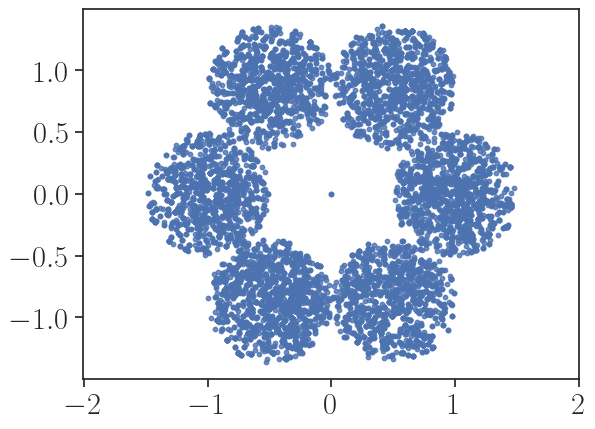

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mh_pot, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
def V_log(x) :

    d, N_mh = sample_mh_pot.shape
    k_inter = lambda j : K_log(x, sample_mh_pot[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext(x) - v_inter

In [ ]:
def V_log_wo_burn(x):

    sample_mh_pot_wo_burn = sample_mh_pot[:, 100:]
    d, N_mh = sample_mh_pot_wo_burn.shape
    k_inter = lambda j : K_log(x, sample_mh_pot_wo_burn[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext_R(x, 1+1/d) - v_inter

## MALA

In [ ]:
key, _ = random.split(key, 2)
N = 1_000
beta_N = N**2
target = gibbs(d, N, K_log, V_log_wo_burn, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))
#start_sample = sample_mh_pot[:, (10_000 - N ):].reshape(1, d*N)

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 5_000,
                               step_size =  0.4*beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [ ]:
acceptance

Array([0.4808], dtype=float64, weak_type=True)

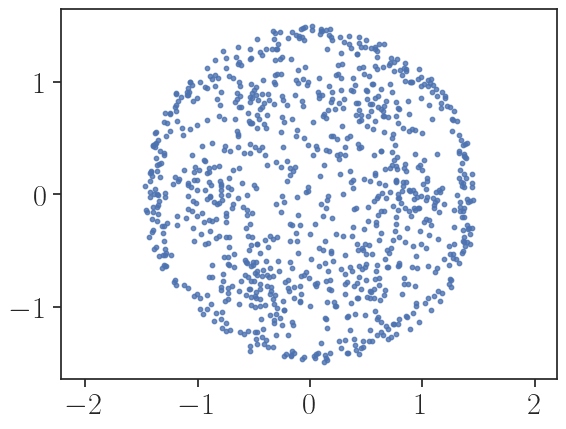

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
fig.savefig("multimodal_cold_5_000.pdf")

(-1.6102331992877386,
 1.4721154063740194,
 -1.4607278233050671,
 1.416122687155161)

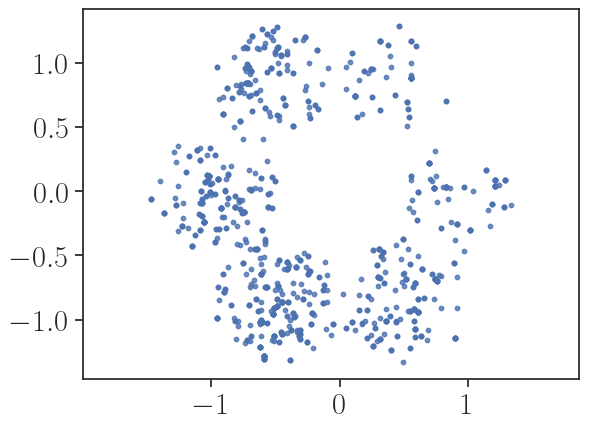

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mh_pot[:, (10_000 - N):], alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

(-3.9698513879206607, 3.311912675790021, -3.808180338929995, 3.629794927511992)

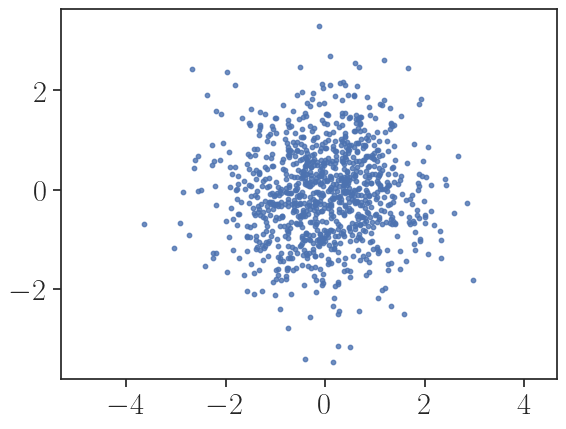

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*start_sample.reshape(d, N), alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])
centers[0]

Array([-1.0000000e+00,  1.2246468e-16], dtype=float64)

In [ ]:
def left_ball(x) :


    centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])
    R = 1.5
    res = cond(jnp.linalg.norm(x - centers[0]) <= R,
               lambda _ : 1.,
               lambda _  :0.,
               None)
    return res

jit(vmap(left_ball))(jnp.array([sample_mh_pot[:, k] for k in range(10_000)])).sum()/10_000


Array(0.4825, dtype=float64)

In [ ]:
1.5/(1.5+0.5)

0.75

## Stein points / gradient descent / quenched / importance sampling pour un warm start, puis Gibbs

In [ ]:
pip install ksddescent

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
from ksddescent import ksdd_lbfgs

In [ ]:
import numpy as np
sigma = np.sqrt(0.1)
centers = torch.from_numpy(np.array([np.array([np.cos(2*k*np.pi/n_modes), np.sin(2*k*np.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])).float()

In [ ]:
def score_mixt(x, beta = 1) :
    den = 0
    top = 0
    weight = 1/n_modes
    var = sigma**2
    for k in range(n_modes) :
        exp = torch.exp(-0.5 * ((x - centers[k]) ** 2).sum(axis=1) / var)
        den += weight * exp
        top += weight * exp[:, None] * (x - centers[k]) / var
    return -beta * top / den[:, None]

In [ ]:
def K_gauss(x, y) :

    return jnp.exp(-0.5* norm_2_safe_for_grad(x-y))

In [ ]:
x = []
sigma = np.sqrt(0.1)
n, p = 1_000, 2
for k in range(n_modes) :
    z = torch.randn(int(n * 1/n_modes), 2)
    z *= sigma * np.sqrt(1/d)
    z += centers[k]
    x.append(z.clone())
x0 = torch.cat(x)

In [ ]:
n, p = 1_000, 2
x0 = torch.randn(n, p)  # start from uniform distribution
#score = lambda x : x # simple score function
#x0 = x
x = ksdd_lbfgs(x0, score_mixt, max_iter = 50_000)  # run the algorithm

(-4.130425596237183, 4.1471621036529545, -4.05058034658432, 4.100549304485321)

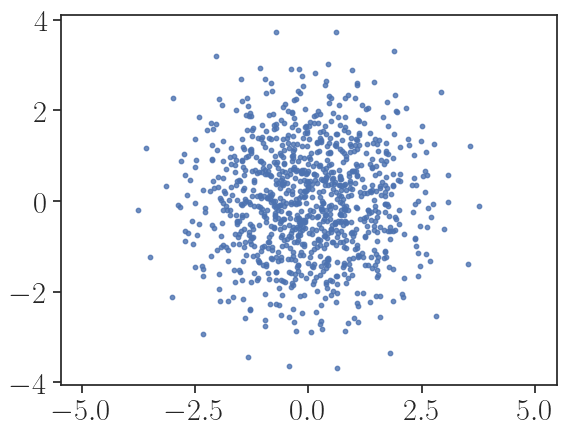

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*x.T, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

(-1.7673720359802245,
 1.7712430000305175,
 -1.6713633060455322,
 1.7153515338897705)

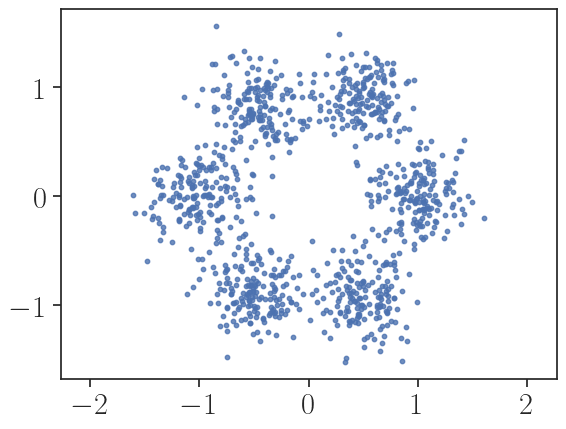

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*x0.T, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

Starting from KSD descent without annealing

In [ ]:
n, p = 1_000, 2
x0 = torch.randn(n, p)  # start from uniform distribution
#score = lambda x : x # simple score function
#x0 = x
x = ksdd_lbfgs(x0, score_mixt, max_iter = 50_000)  # run the algorithm
start_sample = jnp.array(x, dtype = 'float64').T.reshape(1, d*N)

In [ ]:
start_sample.dtype

dtype('float64')

In [ ]:
N = 1_000
start_sample = jnp.array(x, dtype = 'float64').T.reshape(1, d*N)
key, _ = random.split(key, 2)
beta_N = N**2
target = gibbs(d, N, K_log, V_log_wo_burn, beta_N)

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 15_000,
                               step_size =  0.4*beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)
acceptance

Array([0.81053333], dtype=float64, weak_type=True)

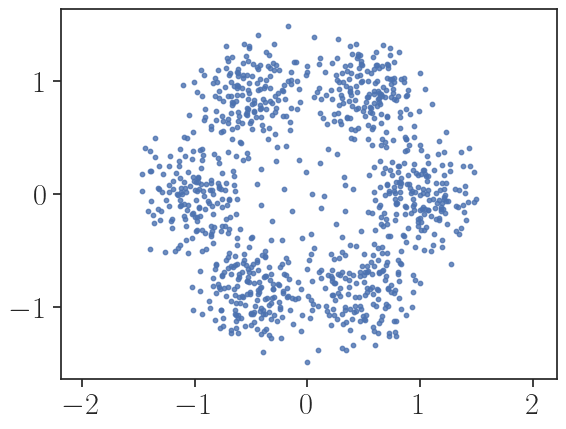

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
fig.savefig("multimodal_ksd_15_000.pdf")

(-1.9637741208076478,
 2.0757166504859925,
 -1.9720567405223846,
 1.9540133416652679)

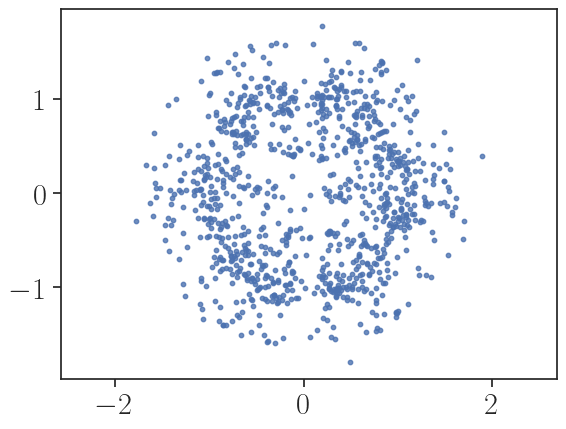

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*x.T, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

Starting from KSD descent with annealing

In [ ]:
l_beta = [k/10 for k in range(1, 11)]
n, p = 1_000, 2
x0 = torch.randn(n, p)  # start from uniform distribution
#score = lambda x : x # simple score function
for k in range(10):
    score_beta = lambda x0 : score_mixt(x0, beta = l_beta[k])
    x  = ksdd_lbfgs(x0, score_beta, max_iter = 50_000)  # run the algorithm
    x0 = x

(-2.087143671512604,
 2.1294143319129946,
 -1.9610541462898254,
 1.9905274510383606)

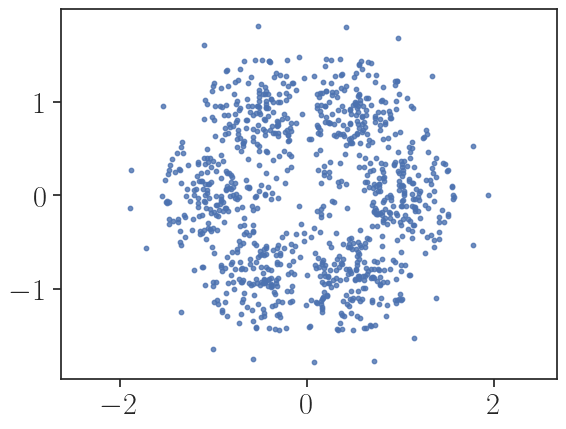

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*x.T, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
start_sample = jnp.array(x, dtype = 'float64').T.reshape(1, d*N)
key, _ = random.split(key, 2)
N = 1_000
beta_N = N**2
target = gibbs(d, N, K_log, V_log_wo_burn, beta_N)

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 5_000,
                               step_size =  0.4*beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)
acceptance

Array([0.6636], dtype=float64, weak_type=True)

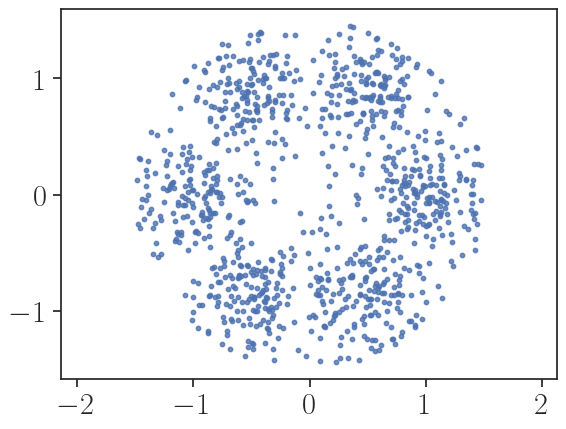

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
fig.savefig("multimodal_ksd_anneal_5_000.pdf")

## Cold start with annealing and comparing warm starts

In [ ]:
def approx_pot_annealing(beta, key, n_iter_pot = 10_000) :

    #Initialize MH
    key, _ = random.split(key, 2)
    n_modes = 6
    n_iter_pot = n_iter_pot
    #target_pot = unif_mixture(d, n_modes, jnp.array([1.2, 0.5]))
    target_pot = gaussian_trunc_mixture(d, n_modes)
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.1*jnp.eye(d))
    start_sample = mvn.sample(key, (1, ))
    initial_positions = start_sample

    logp_annealed = lambda x : beta* target_pot.log_prob(x)
    #Run MCMC to approximate the potential and define V = - U^{\pi} + V_ext
    sample_mh_jit = vmap(partial(mh,
                                log_prob_target = logp_annealed,
                                n_iter = n_iter_pot,
                                step_size = 0.1))

    sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
    sample_mh_pot = sample_mh_pot_jit[1, :, :].T

    return sample_mh_pot


In [ ]:
def V_log_wo_burn(x, mh_pot, ker = "log"):

    sample_mh_pot = mh_pot

    sample_mh_pot_wo_burn = sample_mh_pot[:, 100:]
    d, N_mh = sample_mh_pot_wo_burn.shape
    if ker == "log" :
        k_inter = lambda j : K_log(x, sample_mh_pot_wo_burn[:, j])
    elif ker == "gauss" :
        k_inter = lambda j : K_gauss(x, sample_mh_pot_wo_burn[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext_R(x, 1+1/d) - v_inter

In [ ]:
l_beta = [k/10 for k in range(1, 11)]
key, _ = random.split(key, 2)
N = 1_000
beta_N = N**2
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))
acceptances = []

In [ ]:
x = start_sample
for k in range(10):
    key, key_pot, key_mala, _ = random.split(key, 4)
    sample_pot = approx_pot_annealing(l_beta[k], key_pot, n_iter_pot = 10_000)
    V_annealed = lambda x : V_log_wo_burn(x, sample_pot, ker = "log")
    target = gibbs(d, N, K_log, V_annealed, beta_N)
    sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 1_500,
                               step_size =  0.4*beta_N**-1)))(random.split(key_mala, 1), x)
    acceptances.append(acceptance)
    x = sample_mala

sample_mala_reshaped = x.reshape(d, N)
acceptances

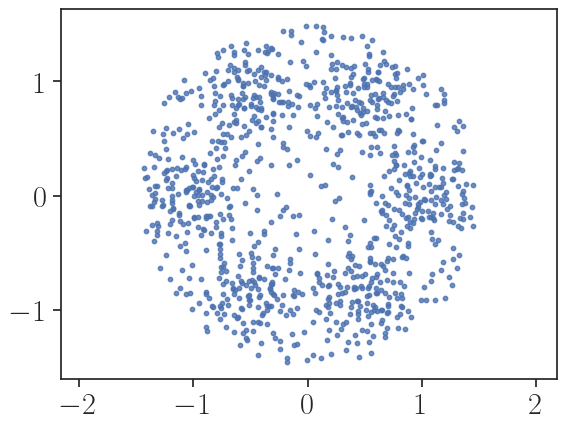

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
fig.savefig("multimodal_cold_anneal_15_000.pdf")

In [ ]:
l_beta = [k/10 for k in range(1, 11)]
key, _ = random.split(key, 2)
N = 1_000
beta_N = N**2
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))
acceptances = []

In [ ]:
x = start_sample
key, key_pot, key_mala, _ = random.split(key, 4)
sample_pot = approx_pot_annealing(1., key_pot, n_iter_pot = 10_000)
V_annealed = lambda x : V_log_wo_burn(x, sample_pot, ker = "log")
target = gibbs(d, N, K_log, V_annealed, beta_N)
for k in range(10):
    log_p_beta = lambda x : l_beta[k]*target.log_prob(x)
    sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = log_p_beta,
                               n_iter = 1_000,
                               step_size =  0.4*beta_N**-1)))(random.split(key_mala, 1), x)
    acceptances.append(acceptance)
    x = sample_mala

sample_mala_reshaped = x.reshape(d, N)
acceptances

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
fig.savefig("multimodal_cold_anneal_5000.pdf")

Mesure de convergence en fonction du nombre d'itérations de MALA pour les différentes approches pour voir comment le warm start aide : plot $I_K(\mu_{n, T} - \pi)$ pour : Gibbs avec T iterations (et approx du pot d'ordre N), KSD annealed avec T iterations, Gibbs avec T iterations et annealed,   Gibbs starté en iterations de KSD, Gibbs starté en KSD annealed (rq : pas de sens de comparer à T iterations de KSD car pas la même target (il faut support pas compact, + choix du noyau ?), comparer à MCMC : ultimately on aimerait bien mais on est juste en train de dire que mala (avec cible différente ferait mieux que mcmc avec cible $\pi$ : mais le coût computationnel est pas du tout le même, mais expensive integrands... tout l'intérêt est qu'on a besoin de moins de particules donc coût computationnel ok : mais du coup il faut pas comparer avec le même nombre de particules)

In [ ]:
def mala_w_pos(key: Array,
         start_sample: Array,
         log_prob_target: Callable[[jnp.ndarray], jnp.ndarray],
         n_iter: int,
         step_size: float) -> jnp.ndarray:
    '''
    This function implements MALA sampler.
    :param key: PRNGArray specifying the key that is used for the random numbers
    :param start_sample: Array with the first element
    :param log_prob_target: Function that calculates the log probability of the target distribution at a given point.
    :param n_iter: int The number of steps of the chain.
    :param step_size: The step size (gamma above) for the Langevin kernel.
    :return: The last sample of the chain
    '''
    val = (start_sample, key, 0.)
    #you need to define the gradient of the log_prob_target parameter
    grad_logpdf = grad(lambda x: log_prob_target(x))

    def mh_step(i, val):

        positions, key, acceptance = val
        sample = positions[i-1, :]
        key, subkey_u, subkey_sample = random.split(key, 3)
        #Sample the langevin kernel

        noise = random.normal(subkey_sample, (sample.shape[-1],))
        next = sample + step_size * grad_logpdf(sample) \
               + jnp.sqrt(2 * step_size) * noise
        #Compute the log acceptance ratio
        fwd_ker_logprob = - (noise ** 2).sum() / 2
        bwd_ker_logprob = - ((sample - next - step_size * grad_logpdf(next))**2).sum() / (4 * step_size)
        log_ratio = log_prob_target(next) + bwd_ker_logprob - log_prob_target(sample) - fwd_ker_logprob



        log_u = jnp.log(random.uniform(subkey_u))
        accept = log_ratio > log_u
        acceptance = (i*acceptance + accept)/(i+1)

        x = cond(accept,
                 lambda _: next,
                 lambda _: sample,
                 None)
        positions = positions.at[i, :].set(x)

        return (positions, key, acceptance)

    all_positions = jnp.zeros((n_iter,)+start_sample.shape)
    positions, key, acceptance = fori_loop(1,
                          n_iter,
                          body_fun=mh_step,
                          init_val=(all_positions, key, 0.))
    return positions, acceptance

In [ ]:
#do 5 values from 5000 to 25_000 iterations (restrict to 1_000 iterations for approx of the potential)
#for each value, run 50 times and compute the variance (compared to the previous variance xps we can use the same chain it should be quicker, but we have a lot more iterations..)
#l_gibbs_cold = []
l_gibbs_ksd = []
l_gibbs_cold_annealed = []
l_gibbs_ksd_annealed = []
N = 100
beta_N = N**2
N_chains = 1

In [ ]:
l_var_mixture = {"N" : 100,
               "kernel" : "truncated log",
               "temp" : "n^2",
               "N_chains" : 1,
               "n_iter_pot" : 1000,
               "step_size" : 0.2,
               "cold_start" : l_gibbs_cold,
               "ksd_start" : l_gibbs_ksd,
               "annealed_gibbs" : l_gibbs_cold_annealed,
               "ksd_annealed_start" : l_gibbs_ksd_annealed}

In [ ]:
l_var_mixture = pickle.load(open("drive/MyDrive/l_var_mixture.p", "rb"))
l_gibbs_cold = l_var_mixture["cold_start"]

In [ ]:
dic_gibbs = {"l_gibbs" : l_gibbs_cold}

In [ ]:
def in_mode_1(x) :

    centers = jnp.array([jnp.array([jnp.cos(2*k*jnp.pi/n_modes), jnp.sin(2*k*jnp.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])

    z = x.reshape(d, N)
    radius = 1/d
    val = 0.
    def in_mode_1_i(i, val) :

        res = cond(jnp.linalg.norm(z[:, i] - centers[0]) <= 1/d,
                  lambda _ : 1.,
                  lambda _  :0.,
                  None)
        return val + res
    #return jit(vmap(partial(in_mode_1_i, z)))(jnp.arange(N)).sum()
    val = fori_loop(0,
                    N,
                    body_fun=in_mode_1_i,
                    init_val=0.)
    return val

def averaged_mode_1(c, y, t):

    return jnp.array([in_mode_1(y[c, h, :]) for h in range(t)]).sum()

mode_1_chains = lambda y, t : jit(vmap(partial(averaged_mode_1, y = y, t = t)))(jnp.array([k for k in range(N_chains)])).sum()/N_chains

In [ ]:
#à chaque itération t : ma fonction test sur (x_1, ..., x_N) est le nb de particules qui tombe dans le premier mode
#je moyenne sur les itérations : ça doit converger vers l'espérance sous P_n qui doit être proche de N/6 si la prop dans les modes est préservée
#au lieu de N/6, c'est peut être plutôt la proportion qui est donnée par l'échantillon de mala ?

In [ ]:
centers = torch.from_numpy(np.array([np.array([np.cos(2*k*np.pi/n_modes), np.sin(2*k*np.pi/n_modes)]).reshape(2,) for k in range(1, n_modes+1)])).float()
n, p = 100, 2
x0 = torch.randn(n, p)  # start from uniform distribution
x = ksdd_lbfgs(x0, score_mixt, max_iter = 50_000)  # run the algorithm
start_sample = jnp.array(x, dtype = 'float64').T.reshape(1, d*N)
x = start_sample

In [ ]:
dic_gibbs_ksd = {"l_gibbs_ksd" : l_gibbs_ksd}

In [ ]:
#cold start
key, key_pot, key_mala, _ = random.split(key, 4)
sample_pot = approx_pot_annealing(1, key_pot, n_iter_pot = 10_000)
V_annealed = lambda x : V_log_wo_burn(x, sample_pot)
target = gibbs(d, N, K_log, V_annealed, beta_N)
#mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
#start_sample = mvn.sample(key, (N_chains, ))
nb_mode_1 = 0.
for t in range(15):
    key_mala, _ = random.split(key_mala, 2)
    sample_mala_w_pos, acceptance = jit(vmap(partial(mala_w_pos,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size =  0.2*beta_N**-1)))(random.split(key_mala, N_chains), x)
    x = sample_mala_w_pos[:, -1, :]
    print(acceptance)
    nb_mode_1+= averaged_mode_1(0, sample_mala_w_pos, 1_000)
    l_gibbs_ksd.append(jnp.abs(nb_mode_1/((t+1)*1_000) - N/6.))
    dic_gibbs_ksd["l_gibbs_ksd"] = l_gibbs_ksd
    pickle.dump(dic_gibbs_ksd, open("drive/MyDrive/results_kernel/l_var_gibbs_ksd.p", "wb"))

l_var_mixture["ksd_start"] = l_gibbs_ksd
pickle.dump(l_var_mixture, open("drive/MyDrive/results_kernel/l_var_mixture.p", "wb"))

[0.431]
[0.848]
[0.725]
[0.333]
[0.569]
[0.655]
[0.633]
[0.724]
[0.632]
[0.031]
[0.583]
[0.778]
[0.758]
[0.482]
[0.238]


In [ ]:
key, key_pot, key_mala, _ = random.split(key, 4)
sample_pot = approx_pot_annealing(1, key_pot, n_iter_pot = 10_000)
V_annealed = lambda x : V_log_wo_burn(x, sample_pot)
target = gibbs(d, N, K_log, V_annealed, beta_N)
key_mala, _ = random.split(key_mala, 2)
sample_mala_w_pos, acceptance = jit(vmap(partial(mala_w_pos,
                               log_prob_target = target.log_prob,
                               n_iter = 50_000,
                               step_size =  0.2*beta_N**-1)))(random.split(key_mala, N_chains), x)
i_chapeau = averaged_mode_1(0, sample_mala_w_pos, 50_000)/50_000.
i_chapeau

In [ ]:
l_gibbs_cold_ok = [l_gibbs_cold[i]+ N/6. - i_chapeau for i in range(15)]
l_gibbs_ksd_ok = [-N/6. + i_chapeau - l_gibbs_ksd[i] for i in range(15)]

[Array(5850., dtype=float64), Array(10335., dtype=float64)]

11700

In [ ]:
l_gibbs_ksd = []
dic_gibbs_ksd = {"l_gibbs_ksd" : l_gibbs_ksd}

In [ ]:
#warm ksd start
n, p = 100, 2
x0 = torch.randn(n, p)  # start from uniform distribution
#score = lambda x : x # simple score function
#x0 = x
start_sample = jnp.zeros((N_chains, d*N))
for k in range(N_chains) :
    x = ksdd_lbfgs(x0, score_mixt, max_iter = 50_000)  # run the algorithm
    start_sample = start_sample.at[k, :].set(jnp.array(x, dtype = 'float64').T.reshape(1, d*N)[:, 0])

In [ ]:
#ksd start
key, key_pot, key_mala, _ = random.split(key, 4)
sample_pot = approx_pot_annealing(1, key_pot, n_iter_pot = 1_000)
V_annealed = lambda x : V_log_wo_burn(x, sample_pot)
target = gibbs(d, N, K_log, V_annealed, beta_N)
start_sample = start_sample
x = start_sample
all_x = jnp.zeros((N_chains, 10_000, d*N))
for t in range(10):
    sample_mala_w_pos, acceptance = jit(vmap(partial(mala_w_pos,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size =  0.2*beta_N**-1)))(random.split(key_mala, N_chains), x)
    x = sample_mala_w_pos[:, -1, :]
    all_x = all_x.at[:, t*1000 : (t+1)*1000, :].set(sample_mala_w_pos)
    l_gibbs_ksd.append(var_norm(all_x[:, :(t+1)*1000, :].reshape(N_chains, (t+1)*1000, d, N), (t+1)*1000))
    dic_gibbs_ksd["l_gibbs_ksd"] = l_gibbs_ksd
    pickle.dump(dic_gibbs, open("drive/MyDrive/results_kernel/l_var_gibbs.p", "wb"))

l_var_mixture["ksd_start"] = l_gibbs_ksd
pickle.dump(l_var_mixture, open("drive/MyDrive/results_kernel/l_var_mixture.p", "wb"))
acceptance

Array([0.495, 0.757, 0.896, 0.613, 0.253, 0.615, 0.712, 0.645, 0.65 ,
       0.774, 0.685, 0.826, 0.686, 0.622, 0.606, 0.544, 0.647, 0.132,
       0.846, 0.318, 0.191, 0.629, 0.795, 0.56 , 0.547, 0.698, 0.352,
       0.342, 0.803, 0.818, 0.552, 0.006, 0.668, 0.755, 0.431, 0.56 ,
       0.516, 0.826, 0.577, 0.425, 0.775, 0.532, 0.65 , 0.316, 0.67 ,
       0.65 , 0.619, 0.651, 0.582, 0.701], dtype=float64, weak_type=True)

In [ ]:
#warm ksd annealed start (is it really how i should assess convergence ? the clt says that i will converge at rate t^-1/2 anyway ?)

In [ ]:
#annealed ksd start for N_chains
l_beta = [k/10 for k in range(1, 11)]
n, p = 100, 2
x0 = torch.randn(n, p)  # start from uniform distribution
#score = lambda x : x # simple score function
start_sample = jnp.zeros((N_chains, d*N))
for k in range(10):
    score_beta = lambda x0 : score_mixt(x0, beta = l_beta[k])
    for h in range(N_chains) :
        y0 = x0
        x  = ksdd_lbfgs(y0, score_beta, max_iter = 50_000)  # run the algorithm
        y0 = x
        start_sample = start_sample.at[h, :].set(jnp.array(x, dtype = 'float64').T.reshape(1, d*N)[:, 0])

NameError: name 'torch' is not defined

In [ ]:
l_gibbs_ksd_an = []
dict_gibbs_ksd_an = {"l_gibbs_ksd_an" : l_gibbs_ksd_an}

In [ ]:
#ksd start
key, key_pot, key_mala, _ = random.split(key, 4)
sample_pot = approx_pot_annealing(1, key_pot, n_iter_pot = 1_000)
V_annealed = lambda x : V_log_wo_burn(x, sample_pot)
target = gibbs(d, N, K_log, V_annealed, beta_N)
start_sample = start_sample
x = start_sample
all_x = jnp.zeros((N_chains, 10_000, d*N))
for t in range(10):
    sample_mala_w_pos, acceptance = jit(vmap(partial(mala_w_pos,
                               log_prob_target = target.log_prob,
                               n_iter = 1_000,
                               step_size =  0.2*beta_N**-1)))(random.split(key_mala, N_chains), x)
    x = sample_mala_w_pos[:, -1, :]
    all_x = all_x.at[:, t*1000 : (t+1)*1000, :].set(sample_mala_w_pos)
    l_gibbs_ksd_an.append(var_norm(all_x[:, :(t+1)*1000, :].reshape(N_chains, (t+1)*1000, d, N), (t+1)*1000))
    #dic_gibbs_ksd_an["l_gibbs_ksd_an"] = l_gibbs_ksd_an
    #pickle.dump(dic_gibbs, open("drive/MyDrive/results_kernel/l_var_gibbs.p", "wb"))

l_var_mixture["ksd_start_an"] = l_gibbs_ksd_an
pickle.dump(l_var_mixture, open("drive/MyDrive/results_kernel/l_var_mixture.p", "wb"))
acceptance

In [ ]:
pickle.dump(l_var_mixture, open("drive/MyDrive/l_var_mixture.p", "wb"))

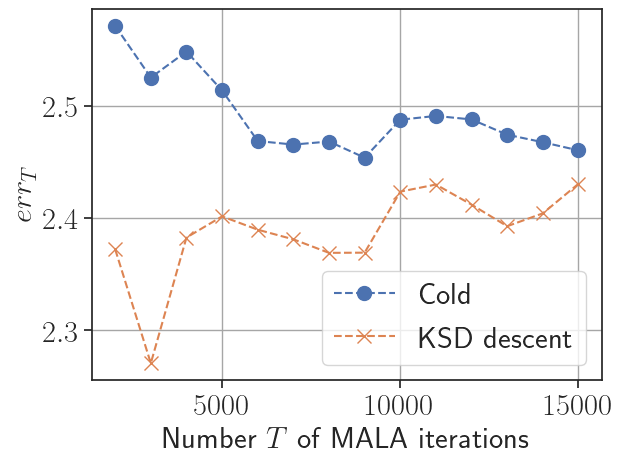

In [ ]:
fig, axes = plt.subplots()

axes.plot(jnp.array([k*1000 for k in range(2, 16)]), jnp.array([l_gibbs_cold])[0, 1:], label = "Cold", linestyle='--', marker='o', markersize = 10)
axes.plot(jnp.array([k*1000 for k in range(2, 16)]), jnp.array([l_gibbs_ksd])[0, 1:], label = "KSD descent", linestyle = '--', marker = 'x', markersize = 10)
#axes.plot(L_N, jnp.log(var_riesz_temp_2), label = "$\\beta_n =  n^2$", linestyle='--', marker='x', markersize = 10)
#axes.plot(L_N, jnp.log(V_mh), label = "MCMC", linestyle='--', marker='^', markersize = 10)

axes.legend()
axes.set_xlabel("Number $T$ of MALA iterations")
axes.set_ylabel("$err_T$")
#axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
fig.savefig("multimodal_linear_stat.pdf")

In [ ]:
#lancer un truc long pour bien estimer la valeur sur 50_000 iterations



# Stein trick

## 2D truncated Gaussian distribution

In [ ]:
d = 2

In [ ]:
class gaussian_trunc(numpyro.distributions.Distribution) :

    def __init__(self, d):

        self.d = d
        self.sigma = 1.
        event_shape = (self.d, )
        super(gaussian_trunc, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        outlier = jnp.linalg.norm(value) >= 1.
        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : -jnp.linalg.norm(value)**2/(2*self.sigma**2),
                   None)

        return res

In [ ]:
def K_gauss(x, y):

    return jnp.exp(-0.5*norm_2_safe_for_grad(x - y))

def b_exp(x) :
    #vanishes on the boundary of the support
    #try to change the constant to reduce the modif of the kernel ?

    b = jnp.exp(-0.1/(norm_2_safe_for_grad(x)-1))
    return b

def k_b(x, y):

    return b_exp(x) *K_gauss(x, y)*b_exp(y)



In [ ]:
def score_pi(x) :

    #put 0 at the boundary to avoid relying on the weight b ?
    outlier = jnp.linalg.norm(x) >= 1.
    res = cond(outlier,
                   lambda _ : jnp.zeros(2),
                   lambda _ : +x/(1.),
                   None)

    return res

def stein_kernel(x, y, k, score_pi) :
    #score_pi = grad log target

    grad_k_x = lambda x, y : grad(lambda x : k(x, y))(x)
    grad_k_y = lambda x, y : grad(lambda y : k(x, y))(y)

    cross_terms = jnp.dot(score_pi(x), grad_k_y(x, y)) + jnp.dot(score_pi(y), grad_k_x(x, y))
    diag_pi = jnp.dot(score_pi(x), score_pi(y))*k(x, y)
    diag_k = grad(lambda x : jnp.dot(grad_k_x(x, y), jnp.ones(d)))(x)

    return diag_k + cross_terms + diag_pi


In [ ]:
#run MALA with usual approximation of the kernel embedding, and Gaussian kernel

In [ ]:
#Initialize MH
key, _ = random.split(key, 2)
n_iter = 10_000
target_pot = gaussian_trunc(d)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.1*jnp.eye(d))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.1))
sample_mh_pot_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_pot = sample_mh_pot_jit[1, :, :].T
acceptance

Array([0.6345], dtype=float64, weak_type=True)

(-1.0751274491211469,
 1.094390862312497,
 -1.0720644275677083,
 1.0637184242083606)

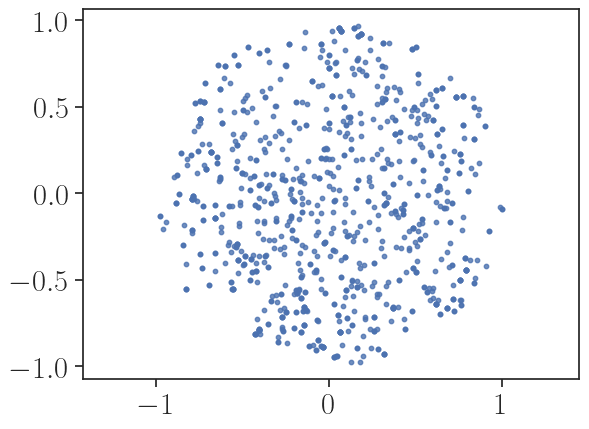

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mh_pot[:, 9000:], alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
def V_ext_R(x, R):

    outlier = norm_2_safe_for_grad(x) >= (R)**2
    res = jnp.where(outlier, norm_2_safe_for_grad(x) - (R)**2, 0.)
    return res

def V_mcmc(x) :

    sample_mh_pot_wo_burn = sample_mh_pot[:, 100:]
    d, N_mh = sample_mh_pot_wo_burn.shape
    k_inter = lambda j : K_gauss(x, sample_mh_pot_wo_burn[:, j])
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / N_mh

    return V_ext_R(x, 1.) - v_inter


def V_stein(x) :

    return V_ext_R(x, 1.)

In [ ]:
key, _ = random.split(key, 2)
d = 2
N = 1_000
beta_N = N**2
target = gibbs(d, N, K_gauss, V_mcmc, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 5_000,
                               step_size =  0.9 * beta_N**(-1))))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [ ]:
acceptance

Array([0.5546], dtype=float64, weak_type=True)

(-1.0557461233845, 1.0928197970149822, -1.069777353783279, 1.0660335498492806)

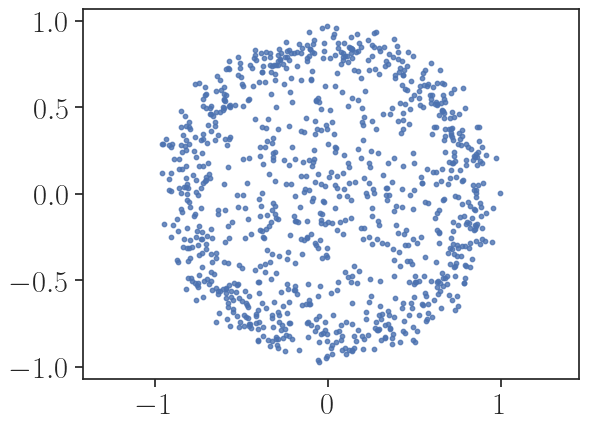

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
#run MALA with the Stein trick : no approximation of the kernel embedding
key, _ = random.split(key, 2)
d = 2
N = 500
beta_N = N**2
k_stein = lambda x, y : stein_kernel(x, y, k_b, score_pi)
target = gibbs(d, N, k_stein, V_stein, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 1*jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 5_000,
                               step_size =  0.9 * beta_N**(-1))))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [ ]:
acceptance

Array([0.], dtype=float64, weak_type=True)

(-0.096125602273171,
 0.09763636749362516,
 -0.1442288457601289,
 0.13121530155755784)

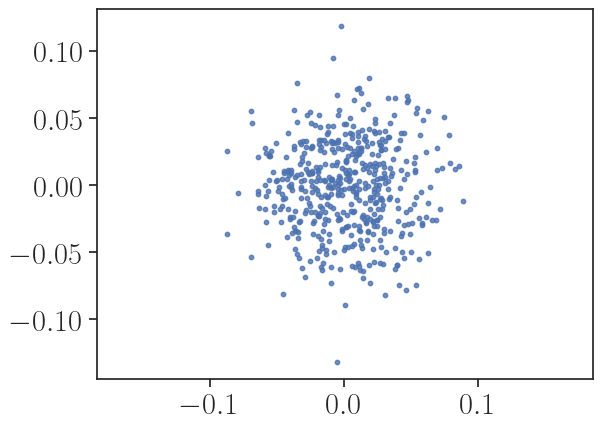

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

# Ex with fully supported target (Gaussian) and log kernel / log confinment

# Quenched for the potential (on verra + tard)

monter la temp petit à petit i.e annealing sur gibbs

mettre à jour le potentiel au fur et à mesure (également le param d'annealing)

Confinement quenched fait chuter l'acceptance à 0 (même avec un start un peu warm mcmc) même pour un cas simple ? (voir ensuite ce qu'on fait pour les mélanges de gaussienne..) schéma itératif idem pour augmenter la temp petit à petit : Itérer à la quenched en augmentant la température petit à eptit (un peu comme du annealing, en prenant les points avec ne petite perturbation pour avoir un bon warm start ?), la loi conditionnelle aura la bonne vitesse

pourquoi on fait pas de l'improtance sampling de base (essayer pour voir ce que ça donne)? pour la concentration pas une stat linéaire ok (c'est pas ce qu'on a montré avec le max du pot ? même si on perd un peu en vitesse..), par contre si on a un CLT par Slutsky on a aussi le CLT avec les poids en supposant la bonne régularité / rkhs pour la fonction de poids (pas clair)

In [ ]:
def V(x) :
    R = 1
    return  0.5*norm_2_safe_for_grad(x)/R**2

target_pi = gaussian_trunc(d)

In [ ]:
key, _ = random.split(key, 2)
d = 2
N = 500
beta_N = N**2
target_pot = gibbs(d, N, K_log, V, beta_N)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= jnp.eye(d*N))
start_sample = mvn.sample(key, (1, ))

In [ ]:
key, _ = random.split(key, 2)
sample_mala_pot, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target_pot.log_prob,
                               n_iter = 10_000,
                               step_size =  0.7*beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped_pot = sample_mala_pot.reshape(d, N)

In [ ]:
acceptance

Array([0.9998], dtype=float64, weak_type=True)

(-1.0488077149734487,
 1.065154837317271,
 -1.082268670712168,
 1.0549644220174792)

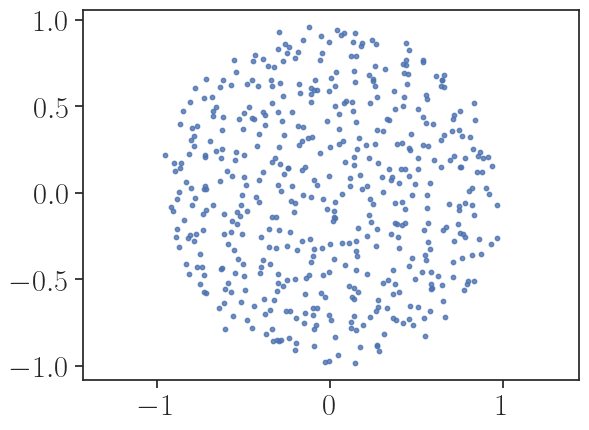

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped_pot, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

In [ ]:
def V_log_quenched(x):

    d, N_mh = sample_mala_reshaped_pot.shape
    W = lambda j : target_pi.log_prob(sample_mala_reshaped_pot[:, j]) #mu_v = unif
    k_inter = lambda j : jnp.exp(W(j) + jnp.log(K_log(x, sample_mala_reshaped_pot[:, j])))
    v_inter = jit(vmap(k_inter))(jnp.array([k for k in range(N_mh)])).sum() / jnp.exp(jit(vmap(W))(jnp.array([j for j in range(N_mh)]))).sum()

    return V_ext_R(x, 1) - v_inter

In [ ]:
target_pi.log_prob(sample_mala_reshaped_pot[:, 125])

Array(-0.12018038, dtype=float64)

In [ ]:
key, _ = random.split(key, 2)
N = 500
beta_N = N**2
target = gibbs(d, N, K_log, V_log_quenched, beta_N) #V_log_quenched fait tomber l'acceptance à 0.. (essayer déjà avec une mes uniforme normale ?)
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.1*jnp.eye(d*N))
#start_sample_noise = mvn.sample(key, (1, )) + sample_mala_pot[:, 1800:] #très cold
start_sample = sample_mala_pot
#start_sample = sample_mh_pot[:, (10_000 - N ):].reshape(1, d*N) #un peu warm

In [ ]:
key, _ = random.split(key, 2)
sample_mala, acceptance = jit(vmap(partial(mala,
                               log_prob_target = target.log_prob,
                               n_iter = 10_000,
                               step_size =  0.7*beta_N**-1)))(random.split(key, 1), start_sample)
sample_mala_reshaped = sample_mala.reshape(d, N)

In [ ]:
acceptance

Array([0.], dtype=float64, weak_type=True)

(-1.1866731240266393,
 1.0812535657798212,
 -1.1083223574589693,
 1.1339549277658427)

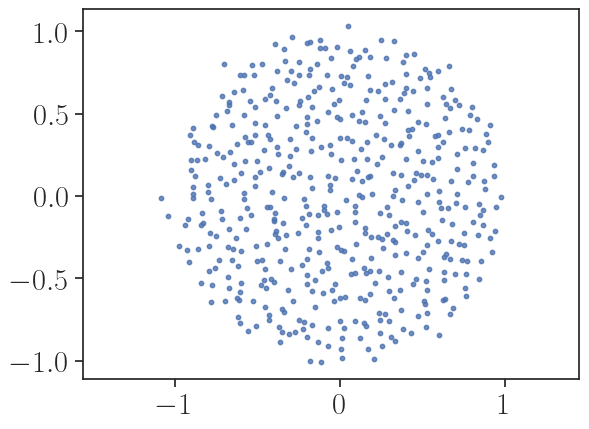

In [ ]:
fig, axes = plt.subplots()
axes.scatter(*sample_mala_reshaped, alpha = 0.8, s = 10)
axes.axis('equal')
#fig.savefig("coulomb_3_2_5000.eps")
#fig.savefig("coulomb_3_2_5000.pdf")

# Plots for truncated gaussian

In [13]:
d = 10
N_max = 500

In [14]:
class gaussian_trunc(numpyro.distributions.Distribution) :

    def __init__(self, d):

        self.d = d
        self.sigma = 1
        event_shape = (self.d, )
        super(gaussian_trunc, self).__init__(event_shape = event_shape)

    def log_prob(self, value) :

        outlier = jnp.linalg.norm(value) >= 1.
        res = cond(outlier,
                   lambda _ : -jnp.inf,
                   lambda _ : -jnp.linalg.norm(value)**2/(2*self.sigma**2),
                   None)

        return res

In [ ]:
#Initialize MH
key, _ = random.split(key, 2)
#N = 1
n_iter = 500
mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d), covariance_matrix= 0.5*jnp.eye(d))
start_sample = mvn.sample(key, (1, ))
initial_positions = start_sample
sample_mh_jit = vmap(partial(mh,
                                log_prob_target = target_pot.log_prob,
                                n_iter = n_iter,
                                step_size = 0.01))
sample_mh_energy_jit, acceptance = jit(sample_mh_jit)(random.split(key, 1), initial_positions)
sample_mh_test = sample_mh_energy_jit[1, :, :].T
I_mh_riesz = jnp.array([I_riesz(sample_mh_test[:, :k]) for k in [50*j for j in range(1, 11)]])
acceptance

Array([0.506], dtype=float64, weak_type=True)

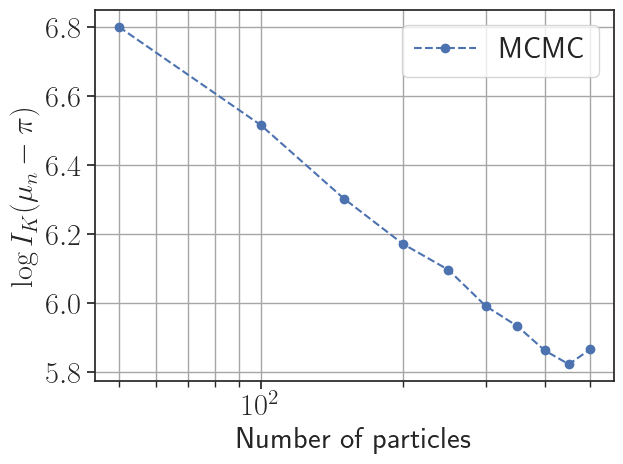

In [ ]:
fig, axes = plt.subplots()

L_N = jnp.array([50*j for j in range(1, 11)])
#$\\mathrm{P}_{n, \\beta_n}^{V}$
axes.plot(L_N, jnp.log10(I_mh_riesz), label = "MCMC", linestyle='--', marker='o')
axes.plot(L_N, jnp.log10(I_riesz_dict_10d['I_decay_riesz']), label = "$\\mathrm{P}_{n, \\beta_n}^{V}$", marker = 'x')
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope=-1., linestyle = "dashed", color = "0.7")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope = -2., linestyle = "dashed", color = "0.7")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("$\\log I_{K}(\\mu_n - \\pi)$")
axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
#fig.savefig("energy_riesz.pdf")
#fig.savefig("energy_riesz.eps")

In [ ]:
def I_N_riesz(N, key, update = "mala", step_size = 1e-3, n_iter = 5_000) :

    key_sample, key_init, _ = random.split(key, 3)
    beta_N = N**2
    mvn = numpyro.distributions.MultivariateNormal(loc=jnp.zeros(d*N), covariance_matrix= 0.5*jnp.eye(d*N))
    start_sample = mvn.sample(key_init, (1, ))
    target = gibbs(d, N, K_riesz, V_riesz, beta_N)

    if update == "mala" :

        sample_gibbs, acceptance = jit(vmap(partial(mala,
                                                    log_prob_target = target.log_prob,
                                                    n_iter = n_iter,
                                                    step_size = step_size)))(random.split(key_sample, 1), start_sample)
        print(acceptance)

    return I_riesz(sample_gibbs.reshape(d, N))

In [ ]:
l_step = jnp.array([0.001, 0.001, 0.002, 0.0007, 0.0001, 0.0, 0.005, 0.005, 0.005, 0.0005, 0.0005])

In [ ]:
key, key_riesz, _ = random.split(key, 3)
keys_mala_tp = random.split(key_riesz, N_max)
I_riesz_dict_10d = {"I_decay_riesz" : [0. for k in range(10)]}
for k in range(1, 11):
    h = 50*k
    I_k = I_N_riesz(h, keys_mala_tp[h],
                                          update = "mala",
                                          step_size =  l_step[k-1] * h**(-2),
                                          n_iter = 5_000)
    I_riesz_dict_10d["I_decay_riesz"][k-1] = I_k #attention rajouter la constante ensuite
    pickle.dump(I_riesz_dict_10d, open("drive/MyDrive/results_kernel/decay_riesz_gauss10d.p", "wb"))

[1.]
[0.626]
[0.297]
[1.]
[1.]
[0.]
[0.8444]
[0.1808]
[0.6208]
[1.]


In [ ]:
jnp.array(I_riesz_dict_10d['I_decay_riesz'])

Array([2000013.16265989, 1000013.22809567,  666679.83833841,
        500013.21361515,  400013.23984763,  333346.56801358,
        285727.50274841,  250013.22449163,  222235.42846157,
        200013.22003844], dtype=float64)

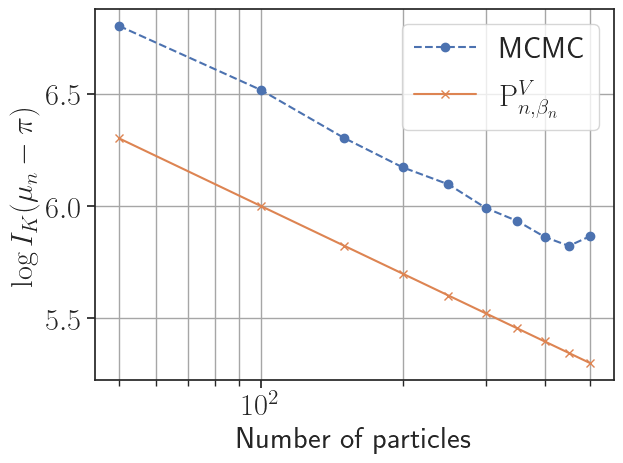

In [ ]:
fig, axes = plt.subplots()

L_N = jnp.array([50*j for j in range(1, 11)])
#$\\mathrm{P}_{n, \\beta_n}^{V}$
axes.plot(L_N, jnp.log10(I_mh_riesz), label = "MCMC", linestyle='--', marker='o')
axes.plot(L_N, jnp.log10(jnp.array(I_riesz_dict_10d['I_decay_riesz'])), label = "$\\mathrm{P}_{n, \\beta_n}^{V}$", marker = 'x')
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope=-1., linestyle = "dashed", color = "0.7")
#axes.axline((50, jnp.log(var_riesz_temp_2[0])), slope = -2., linestyle = "dashed", color = "0.7")

axes.legend()
axes.set_xlabel("Number of particles")
axes.set_ylabel("$\\log I_{K}(\\mu_n - \\pi)$")
axes.set_xscale("log")
plt.grid(True, which="both", ls="-", color='0.65')
plt.tight_layout()
fig.savefig("energy_riesz_gauss10d.pdf")
#fig.savefig("energy_riesz.eps")

In [ ]:
#Variance